# Titanic - Machine Learning from Disaster

Легендарное ML-соревнование с [Kaggle](https://www.kaggle.com/c/titanic)

<img src='./Titanic.jpg' width=500>

Возможно, гибель Титаника - одно из самых печально известных кораблекрушений в истории. Титаник был крупнейшим действующим океанским лайнером своего времени, у него были улучшенные меры обеспечения безопасности, такие как водонепроницаемые отсеки и водонепроницаемые двери с дистанционным управлением. Корабль считался «непотопляемым», однако он затонул рано утром 15 апреля 1912 года в северной части Атлантического океана во время своего первого рейса из Саутгемптона в Нью-Йорк. В момент столкновения корабля с айсбергом на борту находились 2224 человека.

В соответствии с существующей в то время практикой система спасательных шлюпок Титаника была разработана для переправки пассажиров на ближайшие спасательные суда, а не для одновременного удержания всех на плаву. Таким образом, когда корабль быстро тонул (корабль затонул за 2 часа 40 минут), а до прибытия помощи оставалось еще несколько часов, многим пассажирам и членам экипажа не хватило места на спасательных шлюпках, которых было всего 20. Плохая организация эвакуации привела к тому, что многие лодки были спущены на воду до того, как были полностью заполнены.

В результате кораблекрушения погибло более 1500 человек, что сделало его одним из самых смертоносных в истории.

Без сомнения, при спасении пассажиров имел место элемент удачи, но, возможно, были те, кто имели большие шансы уцелеть чем другие. [Titanic ML competition on Kaggle](https://www.kaggle.com/c/titanic) предлагает участникам предсказать кто из пассажиров пережил кораблекрушение, основываясь на сохранившихся данных о пассажирах.

В Интернете можно найти десятки статей, посвященных этому соревнованию, и сотни решений этой задачи. В исследовательском анализе я во многом ориентировался на [эту статью](https://habr.com/ru/company/mlclass/blog/270973/) и позаимствовал из неё несколько идей.

**Примечание**

Терадка состоит из нескольких этапов, некоторые из которых могут занимать продолжительное время, поэтому будем использовать логирование с помощью библиотеки `notifiers` и чатбота в телеграм.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-модулей-и-константы" data-toc-modified-id="Импорт-модулей-и-константы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт модулей и константы</a></span></li><li><span><a href="#Настройка-логирования" data-toc-modified-id="Настройка-логирования-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Настройка логирования</a></span></li><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Примечания-к-признкакм" data-toc-modified-id="Примечания-к-признкакм-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Примечания к признкакм</a></span></li><li><span><a href="#Пути-к-файлам" data-toc-modified-id="Пути-к-файлам-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Пути к файлам</a></span></li><li><span><a href="#Предположения" data-toc-modified-id="Предположения-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Предположения</a></span></li><li><span><a href="#Анализ-таблицы-с-результатами-соревнований" data-toc-modified-id="Анализ-таблицы-с-результатами-соревнований-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Анализ таблицы с результатами соревнований</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Разделения-на-тестовый-и-тренировочный-наборы" data-toc-modified-id="Разделения-на-тестовый-и-тренировочный-наборы-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Разделения на тестовый и тренировочный наборы</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ" data-toc-modified-id="Предварительный-анализ-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Предварительный анализ</a></span></li><li><span><a href="#Детальный-анализ-признаков" data-toc-modified-id="Детальный-анализ-признаков-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>Детальный анализ признаков</a></span><ul class="toc-item"><li><span><a href="#Pclass" data-toc-modified-id="Pclass-12.2.1"><span class="toc-item-num">12.2.1&nbsp;&nbsp;</span><code>Pclass</code></a></span></li><li><span><a href="#Name" data-toc-modified-id="Name-12.2.2"><span class="toc-item-num">12.2.2&nbsp;&nbsp;</span><code>Name</code></a></span></li><li><span><a href="#Sex" data-toc-modified-id="Sex-12.2.3"><span class="toc-item-num">12.2.3&nbsp;&nbsp;</span><code>Sex</code></a></span></li><li><span><a href="#Age" data-toc-modified-id="Age-12.2.4"><span class="toc-item-num">12.2.4&nbsp;&nbsp;</span><code>Age</code></a></span></li><li><span><a href="#SibSp" data-toc-modified-id="SibSp-12.2.5"><span class="toc-item-num">12.2.5&nbsp;&nbsp;</span><code>SibSp</code></a></span></li><li><span><a href="#Parch" data-toc-modified-id="Parch-12.2.6"><span class="toc-item-num">12.2.6&nbsp;&nbsp;</span><code>Parch</code></a></span></li><li><span><a href="#Fare" data-toc-modified-id="Fare-12.2.7"><span class="toc-item-num">12.2.7&nbsp;&nbsp;</span><code>Fare</code></a></span></li><li><span><a href="#Cabin" data-toc-modified-id="Cabin-12.2.8"><span class="toc-item-num">12.2.8&nbsp;&nbsp;</span><code>Cabin</code></a></span></li><li><span><a href="#Ticket" data-toc-modified-id="Ticket-12.2.9"><span class="toc-item-num">12.2.9&nbsp;&nbsp;</span><code>Ticket</code></a></span></li><li><span><a href="#Embarked" data-toc-modified-id="Embarked-12.2.10"><span class="toc-item-num">12.2.10&nbsp;&nbsp;</span><code>Embarked</code></a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-12.3"><span class="toc-item-num">12.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Обработка данных</a></span><ul class="toc-item"><li><span><a href="#Разработка-новых-признаков" data-toc-modified-id="Разработка-новых-признаков-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>Разработка новых признаков</a></span><ul class="toc-item"><li><span><a href="#Title" data-toc-modified-id="Title-13.1.1"><span class="toc-item-num">13.1.1&nbsp;&nbsp;</span><code>Title</code></a></span></li><li><span><a href="#AgeGroup-и-FareGroup" data-toc-modified-id="AgeGroup-и-FareGroup-13.1.2"><span class="toc-item-num">13.1.2&nbsp;&nbsp;</span><code>AgeGroup</code> и <code>FareGroup</code></a></span></li><li><span><a href="#Family" data-toc-modified-id="Family-13.1.3"><span class="toc-item-num">13.1.3&nbsp;&nbsp;</span><code>Family</code></a></span></li><li><span><a href="#isFramily" data-toc-modified-id="isFramily-13.1.4"><span class="toc-item-num">13.1.4&nbsp;&nbsp;</span><code>isFramily</code></a></span></li><li><span><a href="#Cabin" data-toc-modified-id="Cabin-13.1.5"><span class="toc-item-num">13.1.5&nbsp;&nbsp;</span><code>Cabin</code></a></span></li><li><span><a href="#Ticket" data-toc-modified-id="Ticket-13.1.6"><span class="toc-item-num">13.1.6&nbsp;&nbsp;</span><code>Ticket</code></a></span></li><li><span><a href="#Отношения-атрибутов" data-toc-modified-id="Отношения-атрибутов-13.1.7"><span class="toc-item-num">13.1.7&nbsp;&nbsp;</span>Отношения атрибутов</a></span></li></ul></li><li><span><a href="#Оценка-информативности-признаков" data-toc-modified-id="Оценка-информативности-признаков-13.2"><span class="toc-item-num">13.2&nbsp;&nbsp;</span>Оценка информативности признаков</a></span><ul class="toc-item"><li><span><a href="#Конвейер" data-toc-modified-id="Конвейер-13.2.1"><span class="toc-item-num">13.2.1&nbsp;&nbsp;</span>Конвейер</a></span></li><li><span><a href="#Корреляция-между-обучающими-признаками" data-toc-modified-id="Корреляция-между-обучающими-признаками-13.2.2"><span class="toc-item-num">13.2.2&nbsp;&nbsp;</span>Корреляция между обучающими признаками</a></span></li><li><span><a href="#Взаимная-информация-(Mutual-Information)" data-toc-modified-id="Взаимная-информация-(Mutual-Information)-13.2.3"><span class="toc-item-num">13.2.3&nbsp;&nbsp;</span>Взаимная информация (Mutual Information)</a></span></li></ul></li></ul></li><li><span><a href="#Удаление-скоррелированных-признаков" data-toc-modified-id="Удаление-скоррелированных-признаков-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Удаление скоррелированных признаков</a></span></li><li><span><a href="#Функции-для-оценки-моделей" data-toc-modified-id="Функции-для-оценки-моделей-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Функции для оценки моделей</a></span></li><li><span><a href="#Базовая-модель" data-toc-modified-id="Базовая-модель-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Базовая модель</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Выбор модели</a></span></li><li><span><a href="#Настройка-гиперпараметров" data-toc-modified-id="Настройка-гиперпараметров-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Настройка гиперпараметров</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-19"><span class="toc-item-num">19&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li><li><span><a href="#Подготовка-результатов-для-Kaggle" data-toc-modified-id="Подготовка-результатов-для-Kaggle-20"><span class="toc-item-num">20&nbsp;&nbsp;</span>Подготовка результатов для Kaggle</a></span></li></ul></div>

## Импорт модулей и константы

In [1]:
import warnings


from category_encoders.target_encoder import TargetEncoder

import datetime

import joblib

import matplotlib.pyplot as plt

import notifiers

import numpy as np

from optuna.distributions import (CategoricalDistribution,
                                  FloatDistribution,
                                  IntDistribution
                                 )

from optuna.integration import OptunaSearchCV

import pandas as pd

from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy.stats import (percentileofscore,
                         ttest_ind,
                        )

from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import (mutual_info_classif,
                                       SelectKBest,
                                      )

from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score,
                             get_scorer, 
                             roc_curve,
                            )

from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score,
                                     GridSearchCV,
                                     train_test_split,
                                    )

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (Binarizer, 
                                   FunctionTransformer, 
                                   KBinsDiscretizer, 
                                   StandardScaler,
                                  )

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier


warnings.simplefilter(action='ignore', category=FutureWarning)


CV = 5
N_JOBS = -1
SEED = 42


%matplotlib inline

## Настройка логирования

In [2]:
def make_notifier():
    '''Настраивает логирование в телеграм. Возвращает функцию
    для отправки сообщений.
    '''
    
    logger_params = joblib.load('notifier_params.pkl')
    
    def notifier_func(text):
        now = datetime.datetime.now()
        text_with_dt = f'{now.strftime("%d-%m-%Y %H:%M:%S")}\n{text}'
        
        notifier = notifiers.get_notifier(logger_params['notifier'])
        notifier.notify(message=text_with_dt,
                        token=logger_params['token'],
                        chat_id=logger_params['chat_id'],
                       )
        
    return notifier_func
    
set_notification = make_notifier()

In [3]:
set_notification('Titanic - Machine Learning from Disaster\n\nМодули импортированы.\nЛогирование настроено.')

## Описание проекта

**Цель** - предсказать выживет пассажир Тинтаника в кораблекрушении или нет.

**Тип задачи** - классификация (бинарная классификация).

**Целевая метрика** - *accuracy* (точность).

**Желаемое значение целевой метрики:** Табилца с результатами соревнований содержит почти 14000 записей. 
Медианное значение точности 0.775, но менее 4% имеют резутат выше 0.8. 
Таким образом, **значение метрики accuracy больше или равное 0.8 будет отличным результатом**.

**Существующие решения:** имеется огромное количество решений опубликованных в интернете и [на форуме](https://www.kaggle.com/c/titanic/discussion)

## Описание данных
0. **PassengerId** - ID пассажира.
1. **Survived** - Выживший:
    - 0 = Нет, 
    - 1 = Да.
2. **Pclass** - Класс билета:
    - 1 = первый, 
    - 2 = второй, 
    - 3 = третий.
3. **Name** - Имя пассажира, например Braund, Mr. Owen Harris.
4. **Sex** - Пол:
    - male - мужчина,
    - female - женщина.
5. **Age** - Возраст в годах, например 38.0.
6. **SibSp** - Количество братьев и сестер или супругов на борту Титаника.
7. **Parch** - Количество родителей или детей на борту Титаника.
8. **Ticket** - Номер билета, например A/5 21171.
9. **Fare** - Стоимость билета, например 71.2833.
10. **Cabin** - Номер каюты, напрмер C85.
11. **Embarked** - Порт, где пассажир сел на корабль:
    - C = Cherbourg,
    - Q = Queenstown,
    - S = Southampton.
    
**Признаки:** PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket,
Fare, Cabin, Embarked

**Целевой признак** - Survived
    
## Примечания к признкакм
- **pclass**: социально-экономический статус
    - *1st* = Upper
    - *2nd* = Middle
    - *3rd* = Lower
- **age**: Возраст представлен дробным значением, если он меньше 1 года. Если возрас известен, то значение имеет вид xx.5.
- **sibsp**: Количество братьев и сестер или супругов на борту Титаника
    - *sibling* = брат, сестра, сводный брат, сводная сестра
    - *spouse* = муж, жена (любовницы, женихи и невесты игнорировались)
- **parch**: количество родителей (мать, отец)/детей (дочь, сын, в т.ч. приёмные) на борту Титаника. Некоторые дети путешествовали только с няней, поэтому для них parch=0.

## Пути к файлам
- **training set**: ../datasets/train.csv - набор данных для обучения модели.
- **test set**: ../datasets/test.csv - набор для подготовки предсказания для отправки на проверку.
- **example of a submission file**: ../datasets/gender_submission.csv - пример данных, подготовленных для проверки. В нём значения целевой переменной расставлены случайным образом.

## Предположения
У женщин было больше шансов выжить, чем у мужчин.

## Анализ таблицы с результатами соревнований
Скачаем [таблицу с результатами соревнования](https://www.kaggle.com/competitions/titanic/leaderboard) и проанализируем результаты в ней. Таблица загружена 04.02.2023.

Выведем первые 5 строк таблицы.

In [4]:
leaderboard = pd.read_csv('../datasets/titanic-publicleaderboard.csv')
leaderboard.head()

,TeamId,TeamName,SubmissionDate,Score
0,221819,https://bit.ly/TryPrevisionIO,2022-12-06 07:04:39,1.0
1,9577831,DANUSHKUMAR. V,2022-12-06 15:05:10,1.0
2,7943932,Aleksei Fomin,2023-01-28 09:24:51,1.0
3,9583552,sdg888,2022-12-07 16:17:33,1.0
4,9584744,TJ Carpenter,2022-12-08 17:28:28,1.0


Неожиданно в начале таблицы оказались результаты с точностью (метрика *accuracy*) равной 1. Неужели авторы смогли достичь совершенства?

Посчитаем описательные статистики для результатов приведённых в таблице (столбец `Score`).

In [5]:
leaderboard.Score.describe()

count    14118.000000
mean         0.759704
std          0.078944
min          0.000000
25%          0.765550
50%          0.775110
75%          0.777510
max          1.000000
Name: Score, dtype: float64

Посчитаем процент участников показавших результат лучше 0.8.

In [6]:
print(f'Только {1 - percentileofscore(leaderboard.Score, 0.8) / 100 :.2%} участников показали результат лучше 0.8')

Только 3.24% участников показали результат лучше 0.8


Таким образом, **значение метрики accuracy больше или равное 0.8 будет отличным результатом**.

Построим функцию распределения (ECDF) вероятности результатов участников. Красным отметим желаемое значение целевой метрики.

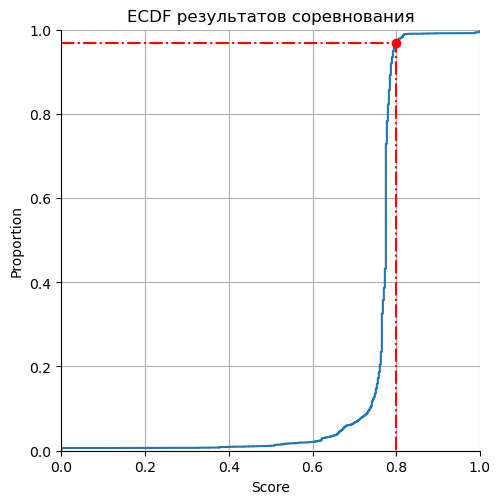

In [7]:
def plot_ecdf_with_target(data, target):
    sns.displot(data, stat='proportion', kind='ecdf', height=5, aspect=1)
    
    quantile = percentileofscore(data, target) / 100
    
    plt.plot([0, target, target], [quantile, quantile, 0], '-.r')
    plt.plot([target], [quantile], 'or')
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
    plt.title('ECDF результатов соревнования')
    
    plt.grid()
    
    plt.show()

    
plot_ecdf_with_target(leaderboard.Score, 0.8)

Построим плотность распределения вероятности получения определённого результата соревнования. Красной стрелкой отметим результаты равные 1.0 .

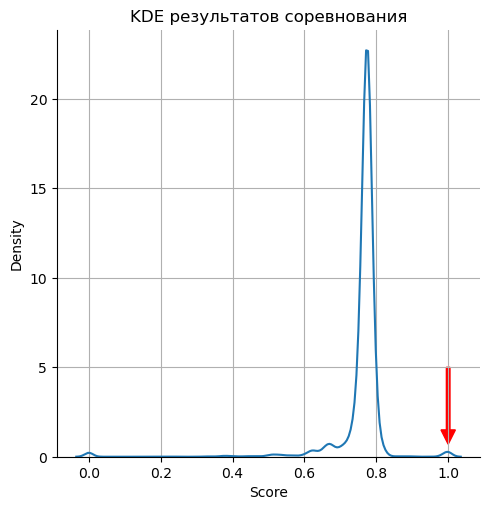

In [8]:
sns.displot(leaderboard, x='Score', kind='kde')

plt.arrow(x=1.0, y=5, dx=0, dy=-3.5, width=0.01, head_width=0.04, head_length=0.8, color='r')
plt.title("KDE результатов соревнования")
plt.grid()

plt.show()

Возможно, решения с "совершенным" результатом появились из-за того, что на [GitHub](https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv) есть точное решение задачи соревнования. Вполен возможно, что выложены данные, извлечённые из [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivors/) или из [OpenML](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active).

Некоторые авторы в своих тетрадках честно предупреждают других пользователей о наличии такой возможности, например [вот этот](https://www.kaggle.com/code/suzukifelipe/how-to-be-a-top-lb-explained-for-beginners/notebook?scriptVersionId=99817039).

Приступим к решению задачи.

In [9]:
set_notification('Выполнен анализ таблицы с результатами соревнования.')

## Загрузка данных
Загрузим набор данных для разработки модели. Далее будем работать с этим набором данных.

In [10]:
data = pd.read_csv('../datasets/train.csv')

Загрузим набор признкаов для отправки результатов на проверку. Отложим этот набор.

In [11]:
submission_X = pd.read_csv('../datasets/test.csv')

In [12]:
set_notification('Выполнена загрузка данных.')

## Знакомство с данными
Выведем форму датасета.

In [13]:
print(f'Датасет содержит {data.shape[0]} строку и {data.shape[1]} столбцов.')

Датасет содержит 891 строку и 12 столбцов.


Выведем на экран первые 10 строк датасета

In [14]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Проверим типы данных признаков и наличие пропусков

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Столбцы `Age`, `Cabin`, `Embarked` содержат пропуски, причём, в столбце `Cabin` пропусков большинство.

Проверим есть ли дисбаланс классов целевой переменной.

In [16]:
def check_target_imbalance(vals):
    mean_val = vals.mean()
    
    print(f'Доля выживших пассажиров - {mean_val: .2%}')
    print(f'Доля погибших пассажиров - {1 - mean_val: .2%}')
    
check_target_imbalance(data.Survived)

Доля выживших пассажиров -  38.38%
Доля погибших пассажиров -  61.62%


В датасете есть дисбаланс классов, поэтому будем использовать стратификацию при разделении на тренировочный и тестовый наборы. Дисбаланс небольшой, и он, скорее всего, отражает объективную реальность, а не является результатом несовершенства сбора данных, поэтому пока оставим его как есть. 

Конечно, может оказаться, что применение какой-либо техники для борьбы с дисбалансом, например апсемплинга, может привести к улучшению результатов.

Проверим наличие дубликатов в наборе данных.

In [17]:
if data.duplicated().any():
    print('В данных есть дубликаты!')
else:
    print('Дубликаты не обнаружены.')

Дубликаты не обнаружены.


In [18]:
set_notification('Выполнено знакомство с данными.')

## Разделения на тестовый и тренировочный наборы
Чтобы обучить модель и спрогнозировать точность её предсказаний на новых данных (результат соревнования) необходимо разделить данные на тестовый и тренировочный наборы. При разделении будем делать стратификацию по целевому признаку.

In [19]:
X = data.drop(columns = 'Survived')
y = data.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Проверим дисбаланс классов в тренировочной выборке

In [20]:
check_target_imbalance(y_train)

Доля выживших пассажиров -  38.34%
Доля погибших пассажиров -  61.66%


Проверим дисбаланс классов в тестовой выборке

In [21]:
check_target_imbalance(y_test)

Доля выживших пассажиров -  38.55%
Доля погибших пассажиров -  61.45%


Пропорции приблизительно одинаковые.

In [22]:
set_notification('Данные разделены на тестовый и тренировочный наборы.')

## Исследовательский анализ

### Предварительный анализ

Распечатаем описательные статистики для числовых признаков

In [23]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,2.308989,29.807687,0.492978,0.390449,31.819826
std,257.465527,0.833563,14.485211,1.060720,0.838134,48.059104
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,3.000000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В таблицу попал категориальный признак `Pclass` рассмотрим его отдельно

In [24]:
X_train[['Pclass']].astype('object').describe()

,Pclass
count,712
unique,3
top,3
freq,391


Выведем описательные статистики для столбцов с типом `object`.

In [25]:
X_train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,712,712,712,160,710
unique,712,2,571,127,3
top,"Lam, Mr. Ali",male,1601,G6,S
freq,1,459,6,4,516


Признак `PassengerID` - уникальный идентификатор пассажира, он не несёт никакой информации. 

Признаки `Name` и `Ticket` имеют слишком большое количество уникальных значений и, скорее всего, не помогут нам. Однако, из признака `Name` можно извлечь титул, который принадлежал человеку, нёс информацию о его социально-экономическом положении и, чисто теоретически, мог влиять на шанс выжить. Из признака `Ticket` можно попробовать извлечь пользу, если предположить, что для пассажиров, которые путешествовали вместе, например одной семьи, этот признак имеет одинаковые значения. Таким образом, попробуем заменить значения признака `Ticket` количеством их повторений.

Признак `Cabin` содержит большое количество пропущенных значений, тем не менее, можно попробовать предположить, что номер каюты известен для выживших пассажиров. Также интересно, что значения этого признака содержат буквы, которые, возможно, обозначали палубы. Таким образом, для пассажиров, для которых значение этого признака неизвестно, будем указывать `'unknown'`, для остальных - первую букву из значения этого признака.

Выведем гистограммы потенциально полезных количественных признаков.

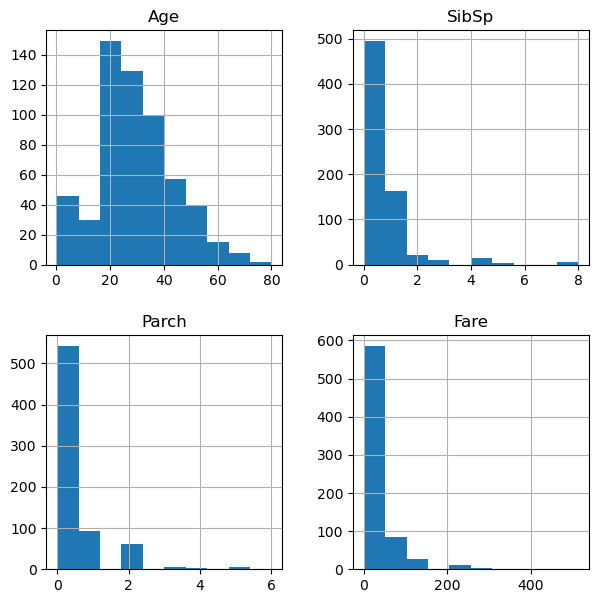

In [26]:
num_columns = ['Age', 'SibSp', 'Parch', 'Fare']

X_train[num_columns].hist(figsize=(7,7))
plt.show()

Распределение пассажиров по возрастам  близко к нормальному, остальные по форме далеки от нормального распределения. Также признаки имеют очень разные масштабы.

Проверим наличие корреляции между количественными признакми.

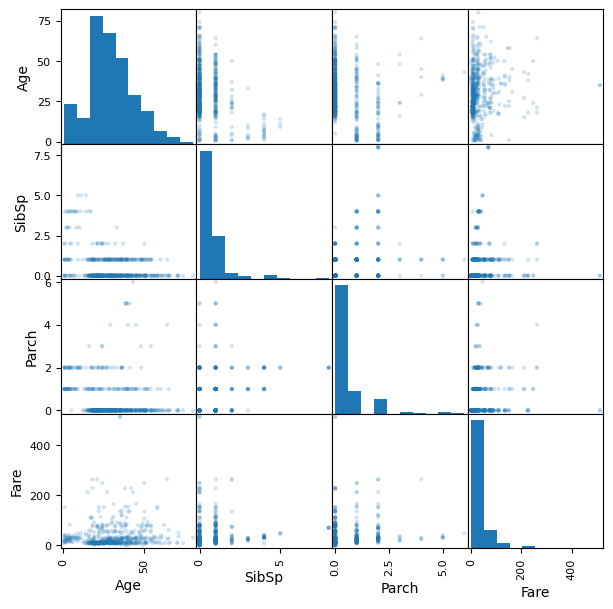

In [27]:
scatter_matrix(X_train[num_columns],
               figsize=(7, 7),
               alpha=0.2,
              )

plt.show()

Построим матрицу корреляции

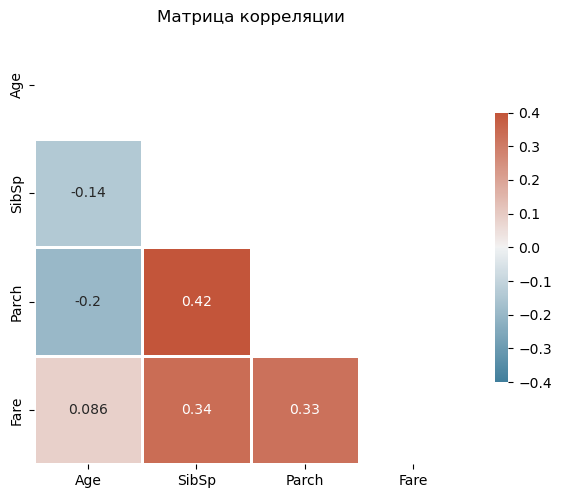

In [28]:
def plot_corr_matrix(df, size=(7, 7), vmin=-1, vmax=1, method='pearson', annot=True):
    corr = df.corr(method=method)
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=size)
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr,
                mask=mask,
                cmap=cmap,
                annot=annot,
                vmax=vmax,
                vmin=vmin,
                center=0.0,
                square=True,
                linewidths=1.0,
                cbar_kws={'shrink': 0.5},
                ax=ax
               )
    
    ax.set_title('Матрица корреляции')
    
    plt.show()
    
plot_corr_matrix(X_train[num_columns], vmin=-0.4, vmax=0.4, method='kendall')

Наблюдается небольшая отрицательная корреляция между признакми `Parch` и `SibSp`.

### Детальный анализ признаков
Рассмотрим каждый признак по отдельности, чтобы найти перспективные преобразования для них и выявить аномалии в данных. Признаки `PassengerId` и `Ticket` рассматривать не будем.

Для этого снова присоединим к набору целевой признак и присвоем их переменной `exploratory_set`.

In [29]:
exploratory_set = pd.concat([X_train, y_train], axis='columns')
exploratory_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1


#### `Pclass`
Посчитаем количество пассажиров для каждого класса билета.

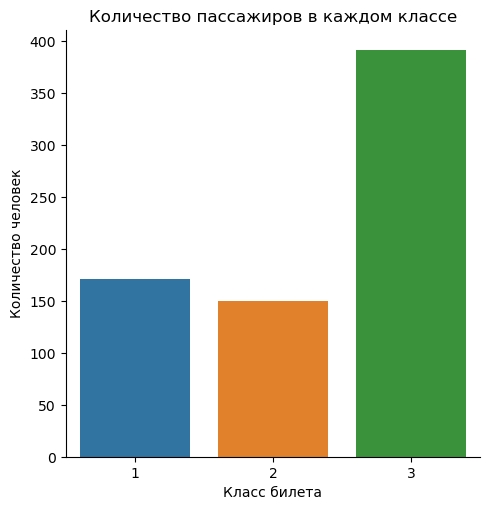

In [30]:
sns.catplot(data=exploratory_set, x='Pclass', kind='count')

plt.title('Количество пассажиров в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Количество человек')

plt.show()

Больше всего пассажиров находились в третьем классе.

Оценим долю выживших для каждого класса.

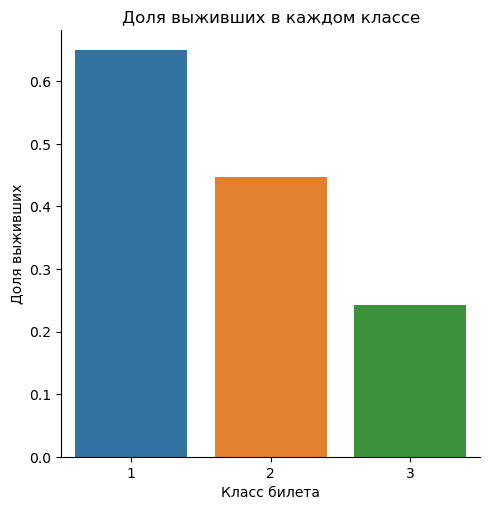

In [31]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Доля выживших')

plt.show()

Самая высока смертность была среди пассажиров третьего класса, возможно, это было связано с тем, что их каюты находились дальше всего от спасательных шлюпок.

Оценим долю выживших для каждого класса в разрезе полов.

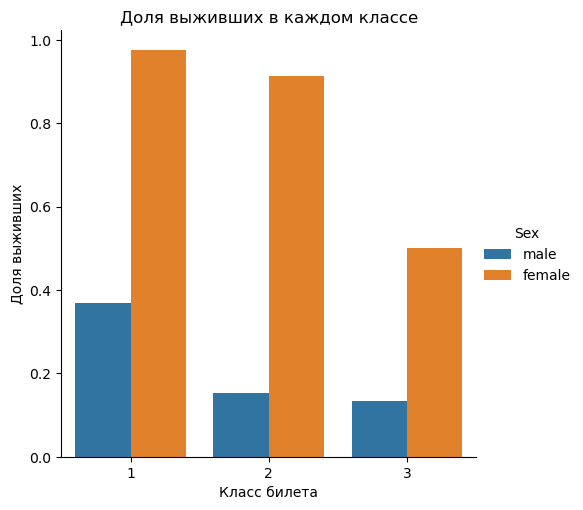

In [32]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', hue='Sex', kind='bar', errorbar=None)

plt.title('Доля выживших в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Доля выживших')

plt.show()

Таким образом, в каждом классе выжило больше женщин, чем мужчин. Самая высокая смертность была среди мужчин третьего класса.

#### `Name`
Имена пассажиров, как мы заметили в предварительном анализе, все уникальны. Однако, они содержат титул, который может указывать на социально-экономический статус пассажира и может быть связан с шансами выжить в кораблекружении.

Выведем первые 5 значений признака `Name`.

In [33]:
exploratory_set[['Name']].head()

,Name
692,"Lam, Mr. Ali"
481,"Frost, Mr. Anthony Wood ""Archie"""
527,"Farthing, Mr. John"
855,"Aks, Mrs. Sam (Leah Rosen)"
801,"Collyer, Mrs. Harvey (Charlotte Annie Tate)"


Выделим новый признак `Title` (титул) и добиви его к `exploratory_set`, затем выведем первые 5 строк получившегося датафрейма.

In [34]:
exploratory_set['Title'] = exploratory_set.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?', expand=True)
exploratory_set['Title'] = exploratory_set['Title'].str.lower()
exploratory_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,mr
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0,mr
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0,mr
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1,mrs
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1,mrs


Посчитаем описательные статистики для нового признака.

In [35]:
exploratory_set[['Title']].describe()

,Title
count,712
unique,14
top,mr
freq,412


Определим количество повторений каждого титула в наборе данных.

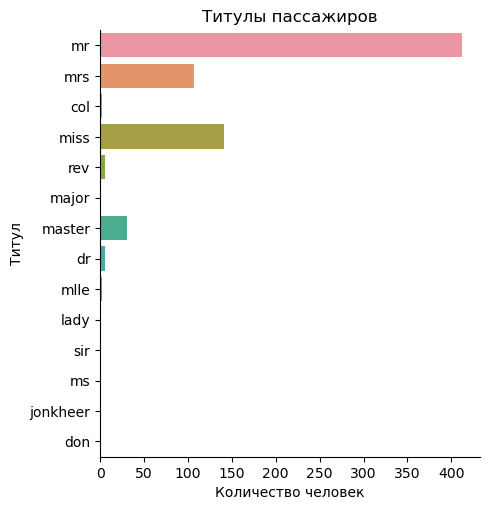

Title
mr          412
miss        141
mrs         107
master       31
dr            6
rev           5
col           2
mlle          2
major         1
lady          1
sir           1
ms            1
jonkheer      1
don           1
Name: count, dtype: int64

In [36]:
sns.catplot(data=exploratory_set, y='Title', kind='count')

plt.title('Титулы пассажиров')
plt.xlabel('Количество человек')
plt.ylabel('Титул')

plt.show()

display(exploratory_set.Title.value_counts(dropna=False))

Обращение *master* в то время использовалось по отношению к младенцам мужского пола. Также признак содержит несколько редко встречающихся титулов. Выведем их, затем вынесем в отдельный список `aristocratic_titles`.

In [37]:
pd.DataFrame(exploratory_set.Title.value_counts()).query('count < 10')

,count
Title,
dr,6
rev,5
col,2
mlle,2
major,1
lady,1
sir,1
ms,1
jonkheer,1


In [38]:
aristocratic_titles = pd.DataFrame(exploratory_set.Title.value_counts()).query('count < 10')
display(aristocratic_titles)

aristocratic_titles = list(aristocratic_titles.index)

,count
Title,
dr,6
rev,5
col,2
mlle,2
major,1
lady,1
sir,1
ms,1
jonkheer,1


Заменим их значением *aristocratic* (аристократический).

In [39]:
exploratory_set.loc[exploratory_set.Title.isin(aristocratic_titles), 'Title'] = 'aristocratic'

Посмотрим как владельцы разных титулов были распределены по классам билетов.

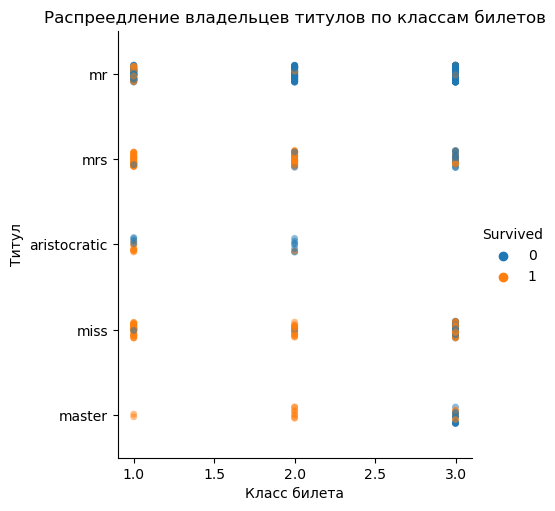

In [40]:
sns.catplot(data=exploratory_set, y='Title', x='Pclass', hue='Survived', orient='h', alpha=0.5)

plt.title('Распреедление владельцев титулов по классам билетов')
plt.xlabel('Класс билета')
plt.ylabel('Титул')

plt.show()

Владельцы аристократических титулов занимали только первый и второй класс.

Оценим долю выживших для каждого титула. Также просматривается некоторая связь между титулом, классом и долей выживших.

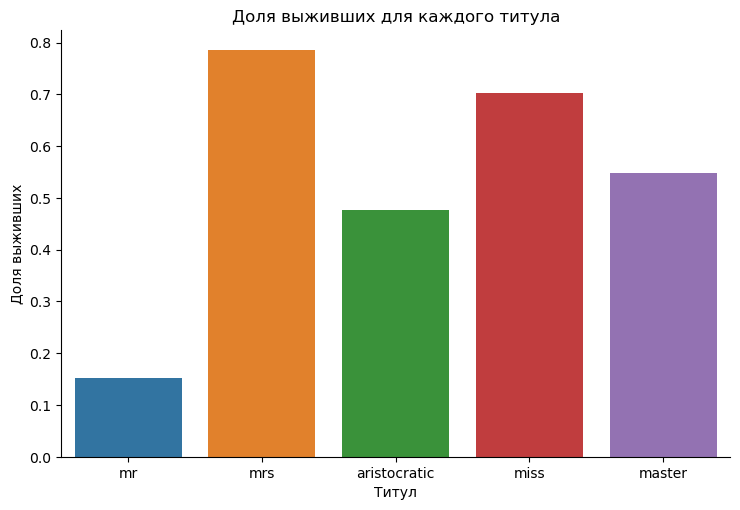

In [41]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', kind='bar', errorbar=None, aspect=1.5)

plt.title('Доля выживших для каждого титула')
plt.xlabel('Титул')
plt.ylabel('Доля выживших')

plt.show()

По смотрим ту же метрику в разрезе полов.

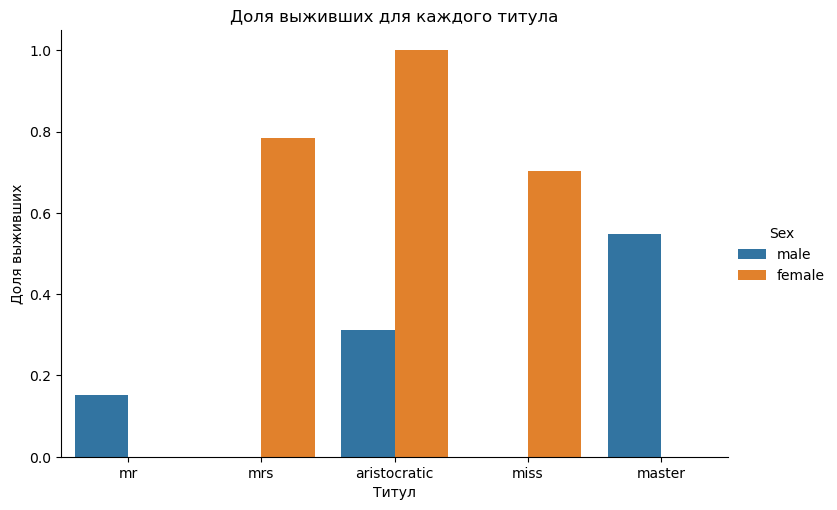

In [42]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', hue='Sex', kind='bar', errorbar=None, aspect=1.5)

plt.title('Доля выживших для каждого титула')
plt.xlabel('Титул')
plt.ylabel('Доля выживших')

plt.show()

Среди мужчин на Титанике аристократы и младенцы имели более высокие шансы спастись.

#### `Sex`
Оценим количество женщин и мужчин, севших на Титаник

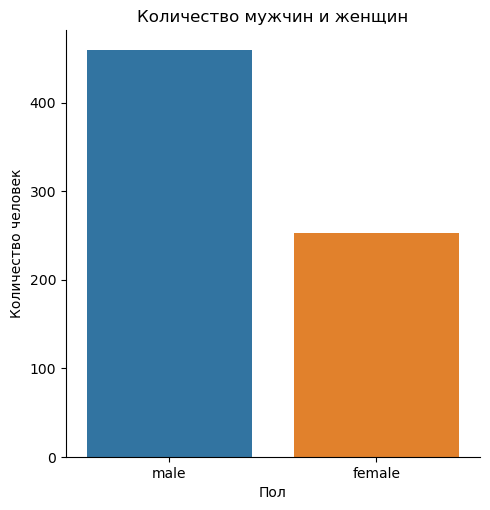

Sex
male      459
female    253
Name: count, dtype: int64

In [43]:
sns.catplot(data=exploratory_set, x='Sex', kind='count')

plt.title('Количество мужчин и женщин')
plt.xlabel('Пол')
plt.ylabel('Количество человек')

plt.show()

display(X_train.Sex.value_counts())

Мужчин на титанике было почти в 2 раза больше чем женщин.

Оценим количество выживших пассажиров каждого пола.

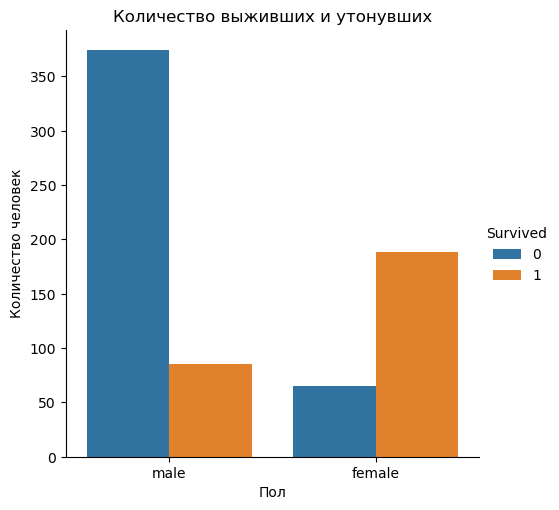

In [44]:
sns.catplot(data=exploratory_set, x='Sex', hue='Survived', kind='count')

plt.title('Количество выживших и утонувших')
plt.xlabel('Пол')
plt.ylabel('Количество человек')

plt.show()

Оценим долю выживших среди мужчин и женщин

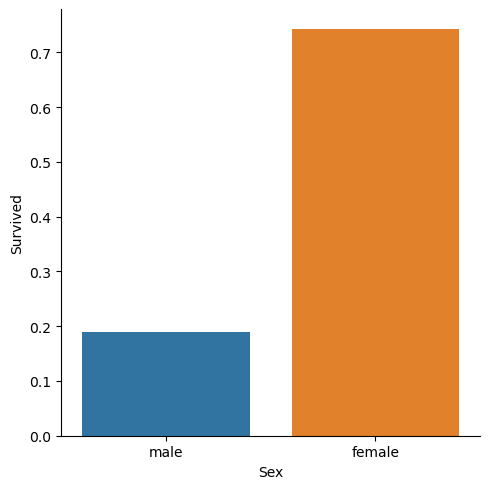

In [45]:
sns.catplot(data=data, x='Sex', y='Survived', kind='bar', errorbar=None)
plt.show()

Женщины на Титанике явно имели более высоки шансы выжить, чем мужчины, что согласуется с правилом "Женщины и дети первые", действовавшим в то время.

#### `Age`

Рассмотрим распределение возрастов пассажиров Титаника, для этого построим гистограмму признака `Age`.

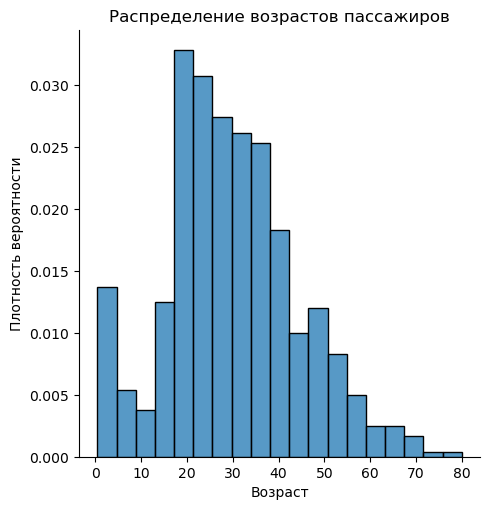

count    575.000000
mean      29.807687
std       14.485211
min        0.420000
25%       21.000000
50%       28.500000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [46]:
sns.displot(exploratory_set.Age, stat='density')

plt.xlabel('Возраст')
plt.ylabel('Плотность вероятности')
plt.title('Распределение возрастов пассажиров')

plt.show()

display(exploratory_set.Age.describe())

Форма распределения отклоняется от формы нормального.

Проверим гипотезу о том, что выжившие пассажиры моложе погибших. Построим распределение возрастов отдельно для погибших и отдельно для выживших.

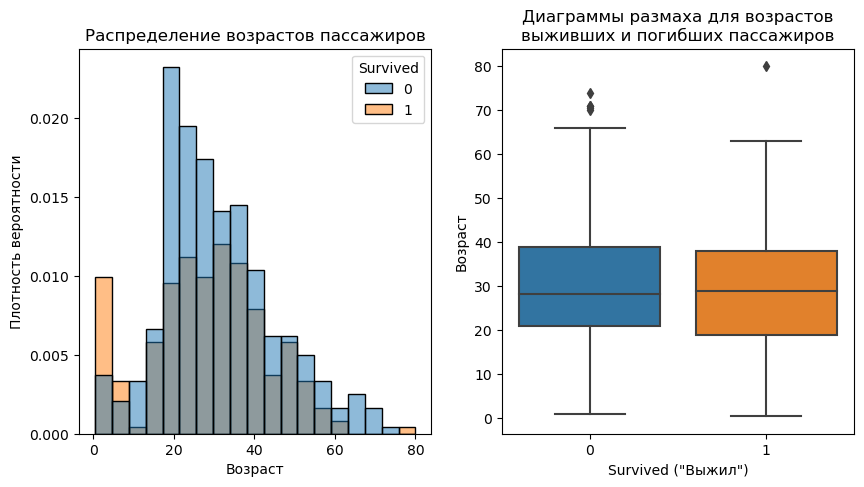

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


sns.histplot(data=exploratory_set, x='Age', stat='density', hue='Survived', ax=ax[0])

ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Плотность вероятности')
ax[0].set_title('Распределение возрастов пассажиров')

sns.boxplot(data=exploratory_set, x='Survived', y='Age', ax=ax[1])

ax[1].set_xlabel('Survived ("Выжил")')
ax[1].set_ylabel('Возраст')
ax[1].set_title('Диаграммы размаха для возрастов\nвыживших и погибших пассажиров')

plt.show()

Распределения накладываются друг на друга, а на диаграммах размаха есть незначительное количество выбросов. Пока что не будем убирать выбросы, так как масимальное значение возраста пассажира равно 80 годам, что выглядит реалистично.

Выполним t-тест, чтобы разобраться была ли разница между средним возрастом выживших и средним возрастом погибших пассажиров. Выдвинем следующие нулевую (**H0**) и альтернативную (**H1**) гипотезы:
- **H0** - средний возраст в обеих группах одинаков;
- **H1** - средний возраст групп различается.

Уровень значимости **p** выберем равным **0.95**.

Прежде чем выполнить тест, расчитаем количество наблюдений в каждой группе, среднее значение и стандартное отклонение.

In [48]:
exploratory_set.groupby('Survived').Age.agg(['count', 'mean', 'std'])

,count,mean,std
Survived,,,
0,342,30.814327,14.121743
1,233,28.330129,14.910473


Выборки имеют разный размер, поэтому установим параметр `equal_var=False` при вызове метода `scipy.stats.ttest_ind()`. 

Также отметим, что средние значения выборок различаются, а стандартные отклонения очень близки, но всё же разные.

Выполним t-тест.

In [49]:
results = ttest_ind(exploratory_set.query('Survived == 0').Age.dropna(),
                    exploratory_set.query('Survived == 1').Age.dropna(),
                    equal_var=False,
                   )

print(f'p-значение: {results.pvalue:.3f}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.046
Отвергаем нулевую гипотезу.


Значение $p$ очень близко к пороговму. Законен вопрос мог ли получисться такой результат из-за выбросов?

Удалим выбросы, для этого в выборках оставим только пассажиров моложе 70 лет, и повторно выполним тест. После очистки данных от выбросов выведем диаграммы размаха и результат тестирования гипотезы.

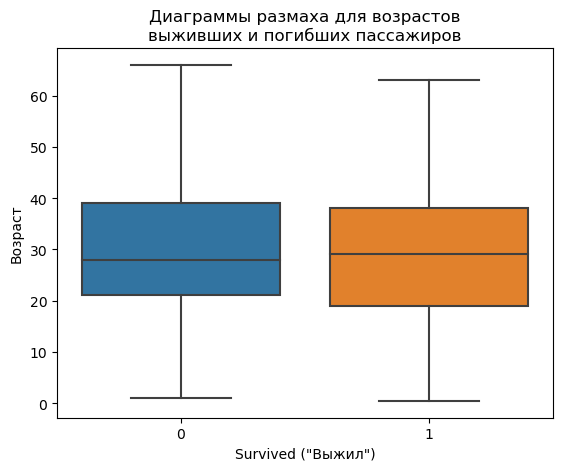

p-значение: 0.080
Не получилось отвергнуть нулевую гипотезу.


In [50]:
sns.boxplot(data=exploratory_set.query('Age < 70'), x='Survived', y='Age')

plt.xlabel('Survived ("Выжил")')
plt.ylabel('Возраст')
plt.title('Диаграммы размаха для возрастов\nвыживших и погибших пассажиров')

plt.show()


results = ttest_ind(exploratory_set.query('Survived == 0 and Age < 70').Age.dropna(),
                    exploratory_set.query('Survived == 1 and Age < 70').Age.dropna(),
                    equal_var=False,
                   )

print(f'p-значение: {results.pvalue:.3f}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Оценим к каком квантилю относится значение 70 (после удаления пропусков).

In [51]:
round(percentileofscore(exploratory_set.Age.dropna(), 70) / 100, 2)

0.99

**Можно подытожить, что у нас нет оснований утверждать, что средний возраст выживших и погибших отличается, или что возраст имел решающее значение при спасении.**

Возраст непрерывная величина, но мы имеем дело с задачей классификации. Может быть целесообразным разбить всех пассажиров на на возрастные группы. В группы с более высокими номерами будем относить пассажиров, которые старше. При этом для дискретизации будем использовать функцию `pd.qcut()`, чтобы в каждой группе оказалось приблизительно одинаковое количество значений.

In [52]:
exploratory_set['AgeGroup'] = pd.qcut(exploratory_set.Age, q=4, labels=list(range(4)))

Проверим количество пассажиров в каждой возрастной групе.

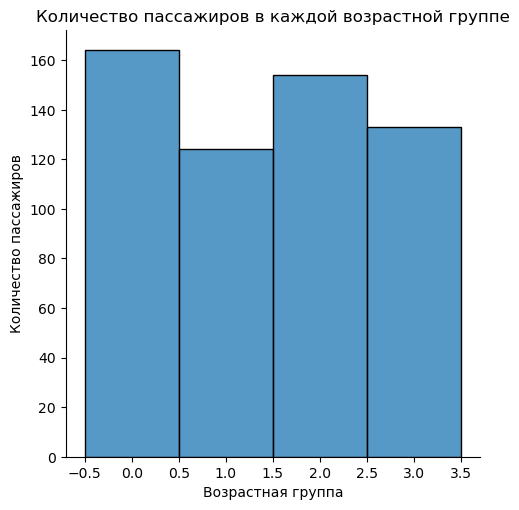

In [53]:
sns.displot(exploratory_set, x='AgeGroup', kind='hist')

plt.title('Количество пассажиров в каждой возрастной группе')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пассажиров')

plt.show()

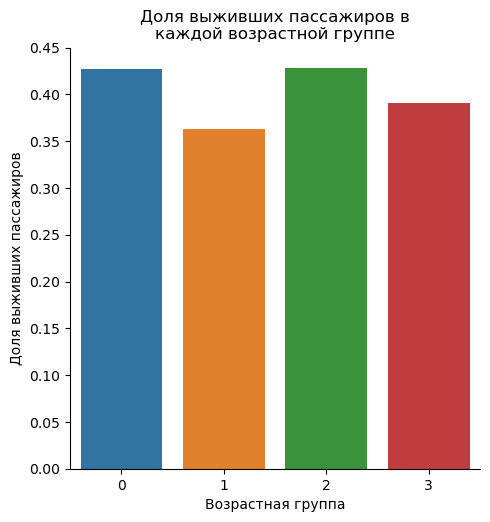

In [54]:
sns.catplot(data=exploratory_set, x='AgeGroup', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших пассажиров в\nкаждой возрастной группе')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля выживших пассажиров')

plt.show()

Ярко выраженной зависимости не наблюдается.

#### `SibSp`

Рассмотрим как распределены значения атрибута `SibSp`.

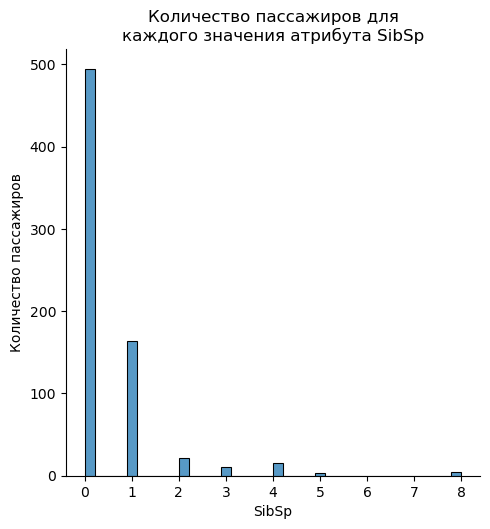

In [55]:
sns.displot(data=exploratory_set, x='SibSp', kind='hist')

plt.title('Количество пассажиров для\nкаждого значения атрибута SibSp')
plt.ylabel('Количество пассажиров')

plt.show()

Оценим долю выживших для каждого значения атрибута `SibSp`.

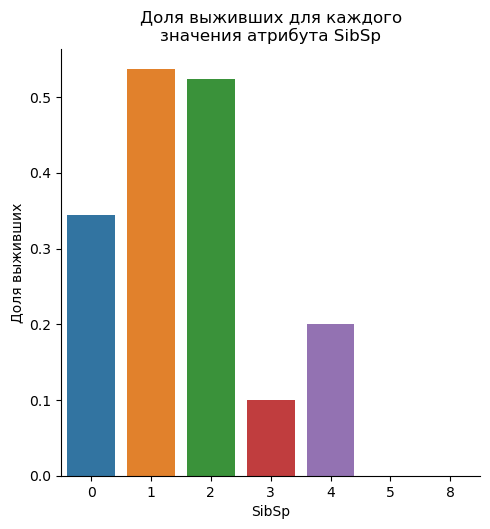

In [56]:
sns.catplot(data=exploratory_set, x='SibSp', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для каждого\nзначения атрибута SibSp')
plt.ylabel('Доля выживших')

plt.show()

#### `Parch`

Рассмотрим как распределены значения атрибута `Parch`.

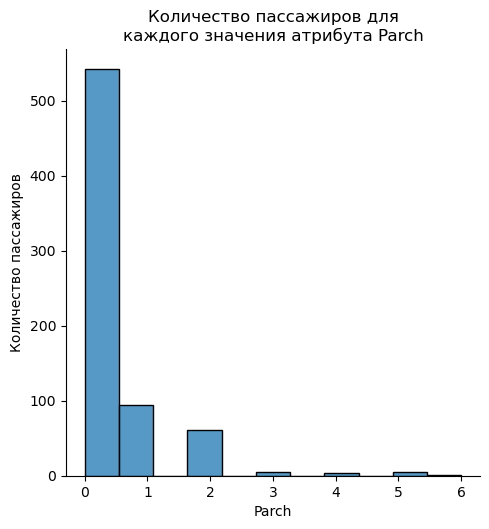

In [57]:
sns.displot(exploratory_set, x='Parch', kind='hist')

plt.title('Количество пассажиров для\nкаждого значения атрибута Parch')
plt.ylabel('Количество пассажиров')

plt.show()

Оценим долю выживших для каждого значения атрибута `Parch`.

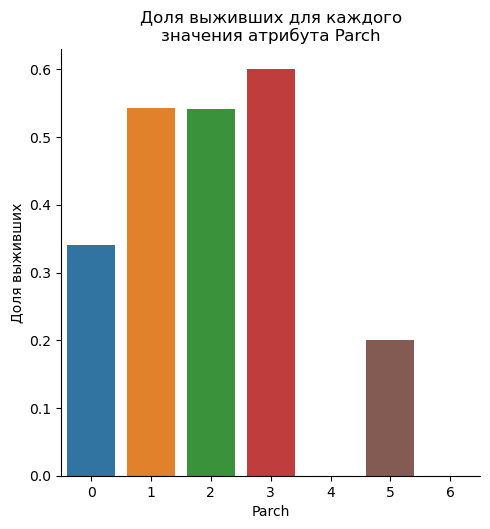

In [58]:
sns.catplot(data=exploratory_set, x='Parch', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для каждого\nзначения атрибута Parch')
plt.ylabel('Доля выживших')

plt.show()

Перспективной может оказаться идея добавить атрибут `Family`, я вляющийся суммой атрибутов `Parch` и `SibSp`.

In [59]:
exploratory_set['Family'] = exploratory_set.Parch + exploratory_set.SibSp

Построим гистограмму признака `Family`.

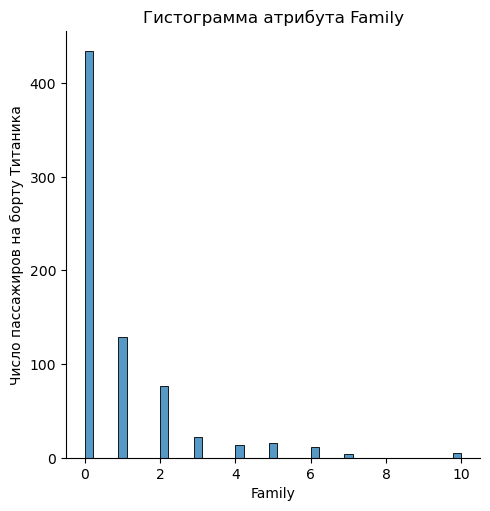

In [60]:
g = sns.displot(data=exploratory_set, x='Family', kind='hist')

plt.ylabel('Число пассажиров на борту Титаника')
plt.title('Гистограмма атрибута Family')

plt.show()

Изучим долю выживших для каждого значения атрибута `Family`

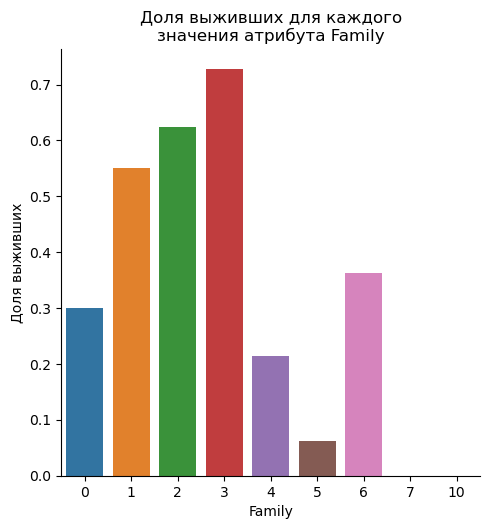

In [61]:
sns.catplot(data=exploratory_set, x='Family', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для каждого\nзначения атрибута Family')
plt.ylabel('Доля выживших')

plt.show()

Также можно попробовать добавить атрибут `isFamily`, который будет равен 1, если пассажир путешествовал с семьёй (если атрибут `Family` больше 0) и в противном случае равен 0.

In [62]:
exploratory_set['isFamily'] = exploratory_set.Family.clip(lower=0, upper=1)

Проверим сколько человек на Титанике путешествовали с семьёй.

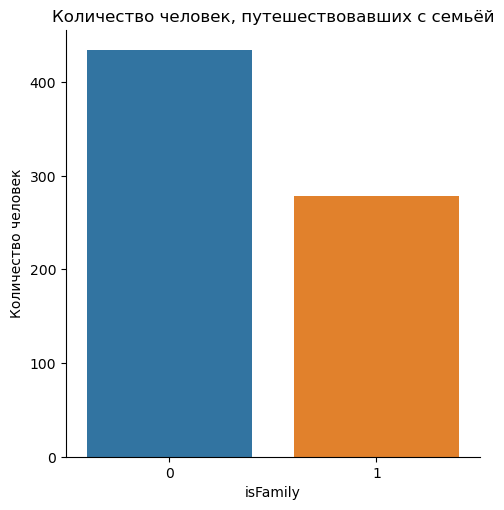

In [63]:
sns.catplot(data=exploratory_set, x='isFamily', kind='count')

plt.title('Количество человек, путешествовавших с семьёй')
plt.ylabel('Количество человек')

plt.show()

Изучим долю выживших в обеих группах.

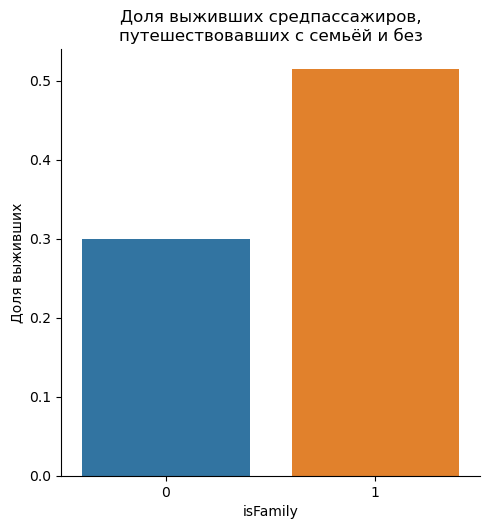

In [64]:
sns.catplot(data=exploratory_set, x='isFamily', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших средпассажиров,\nпутешествовавших с семьёй и без')
plt.ylabel('Доля выживших')

plt.show()

#### `Fare`

Проверим нет ли связи между стоимостью билета и шансом выжить в кораблекрушении. 

Сначала построим гистограмму атрибута `Fare`.

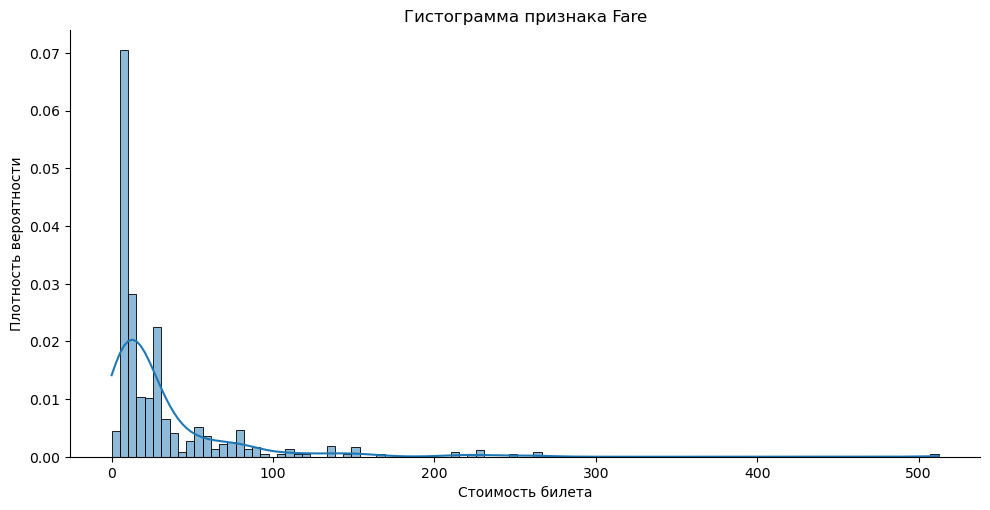

In [65]:
sns.displot(data=exploratory_set, x='Fare', stat='density', aspect=2, kde=True)

plt.title('Гистограмма признака Fare')
plt.xlabel('Стоимость билета')
plt.ylabel('Плотность вероятности')

plt.show()

Распределение имеет "очень тяжёлый хвост".

Посмотрим как распределена стоимость билетов взависимости от класса.

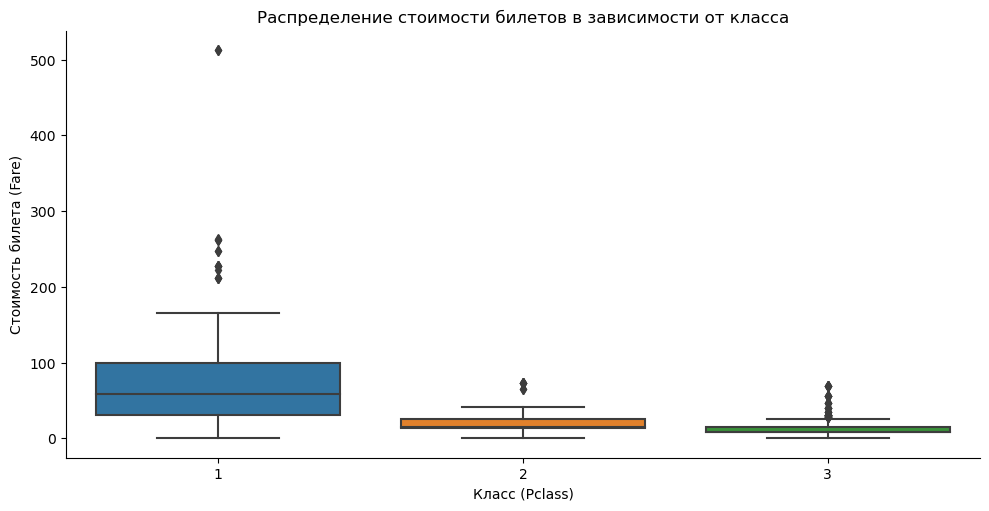

In [66]:
sns.catplot(data=exploratory_set, y='Fare', x='Pclass', aspect=2, kind='box')

plt.title('Распределение стоимости билетов в зависимости от класса')
plt.xlabel('Класс (Pclass)')
plt.ylabel('Стоимость билета (Fare)')

plt.show()

Посмотрим есть ли разница между стомостями билетов погибших и выживших для каждого класса.

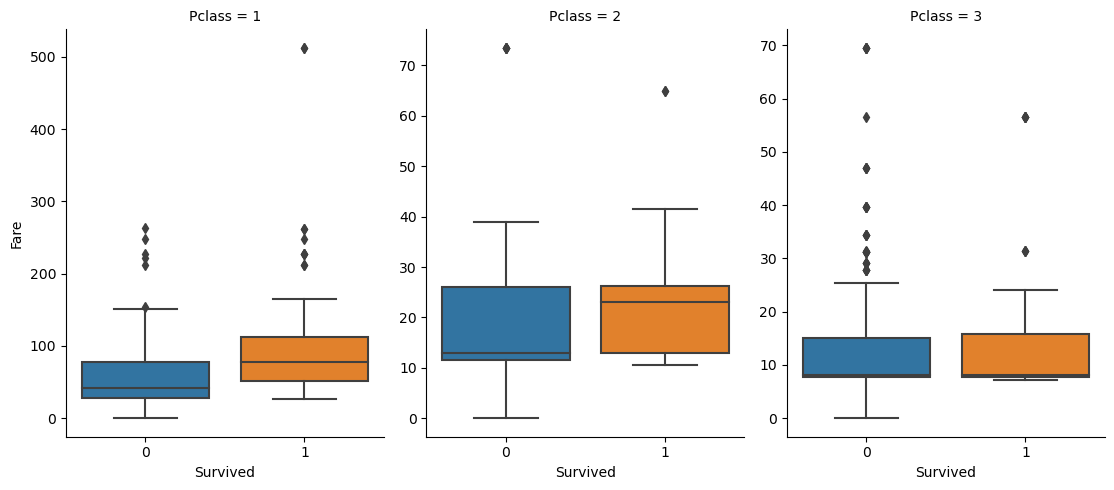

In [67]:
sns.catplot(data=exploratory_set, y='Fare', x='Survived', col='Pclass', sharey=False, kind='box', aspect=0.75)

plt.show()

Явной зависимости не просмативается.

Можно попробовать дискретизировать признак `Fare` аналогично тому как это было сделано с признакоа `Age`.

In [68]:
exploratory_set['FareGroup'] = pd.qcut(exploratory_set.Fare, 4, labels=range(4))

Оценим долю выживших в каждой группе признака `FareGroup`.

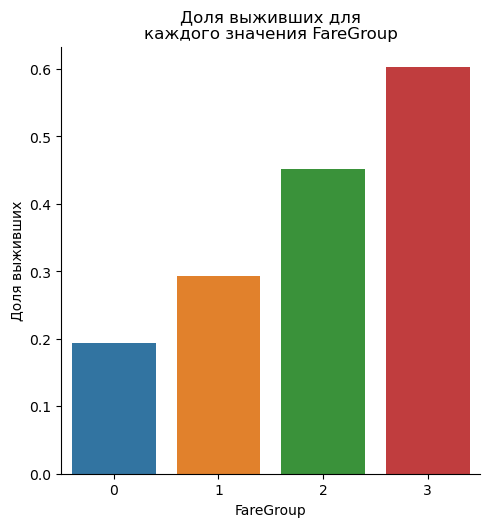

In [69]:
sns.catplot(data=exploratory_set, x='FareGroup', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для\nкаждого значения FareGroup')
plt.ylabel('Доля выживших')

plt.show()

Похоже, пассажиры с более дорогими билетами имели лучшие шансы спастись.

#### `Cabin`

Как было отмечено ранее признка `Cabin` (номер каюты) содержит слишком большое количество уникальных значений и пропусков.

In [70]:
print(f'Признак Cabin содержит {exploratory_set.Cabin.nunique()} уникальных значений.')
print(f'Признак Cabin содержит {exploratory_set.Cabin.isna().sum()} пропусков.')

Признак Cabin содержит 127 уникальных значений.
Признак Cabin содержит 552 пропусков.


Попробуем создать обработать его: пропущенные значения будем заменять значением `'unknown'`, а известные - их первой буквой.

In [71]:
exploratory_set['Cabin'] = data.Cabin.str.slice(stop=1)
exploratory_set.loc[data.Cabin.isna(), 'Cabin'] = 'unknown'

Cabin
unknown    552
C           41
B           34
E           29
D           26
A           14
F           11
G            4
T            1
Name: count, dtype: int64

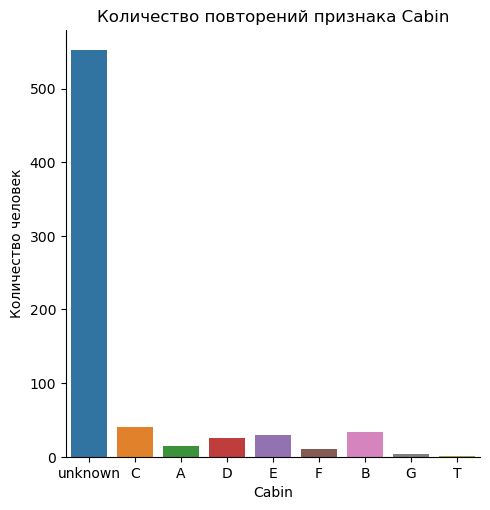

In [72]:
display(exploratory_set['Cabin'].value_counts())

sns.catplot(data=exploratory_set, x='Cabin', kind='count')

plt.title('Количество повторений признака Cabin')
plt.ylabel('Количество человек')

plt.show()

Посмотрим различается ли доля выживших в зависимости от значения признака `Cabin`.

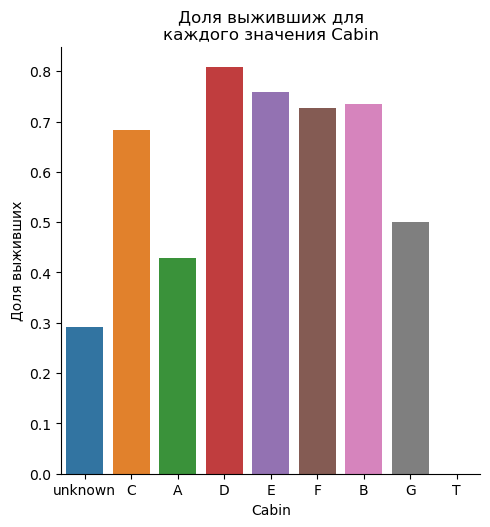

In [73]:
sns.catplot(data=exploratory_set, x='Cabin', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выжившиж для\nкаждого значения Cabin')
plt.ylabel('Доля выживших')

plt.show()

#### `Ticket`
Попробуем обработать значения признака `Ticket`: заменим значения на количество их повторений.

In [74]:
counts = exploratory_set.Ticket.value_counts()
exploratory_set.Ticket = exploratory_set.Ticket.replace(counts)

Ticket
1    476
2    138
3     42
4     24
5     20
6     12
Name: count, dtype: int64

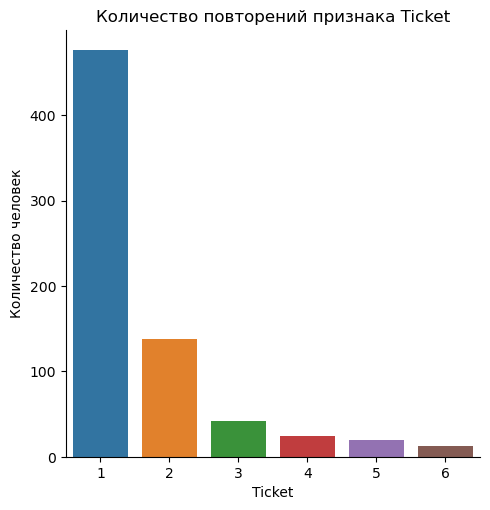

In [75]:
display(exploratory_set['Ticket'].value_counts())

sns.catplot(data=exploratory_set, x='Ticket', kind='count')

plt.title('Количество повторений признака Ticket')
plt.ylabel('Количество человек')

plt.show()

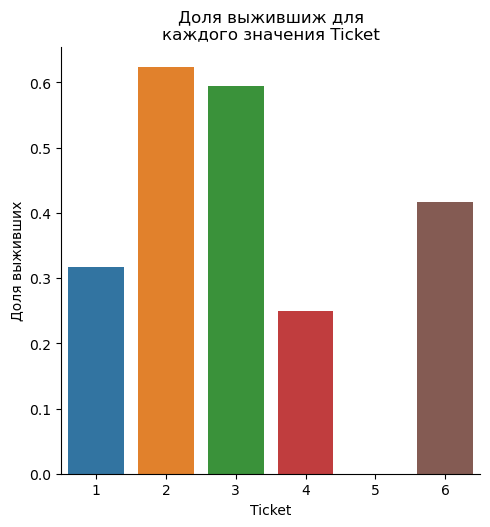

In [76]:
sns.catplot(data=exploratory_set, x='Ticket', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выжившиж для\nкаждого значения Ticket')
plt.ylabel('Доля выживших')

plt.show()

#### `Embarked`

Посмотрим сколько пассажиров село на Титаник в каждом порту.

Embarked
S    516
C    139
Q     55
Name: count, dtype: int64

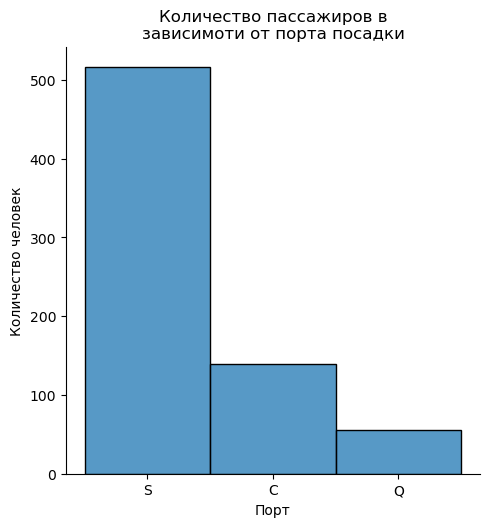

In [77]:
display(exploratory_set.Embarked.value_counts())


sns.displot(data=exploratory_set, x='Embarked', kind='hist')

plt.title('Количество пассажиров в\nзависимоти от порта посадки')
plt.xlabel('Порт')
plt.ylabel('Количество человек')

plt.show()

Больше всего человек село на корабль в Саутгемптоне.

Проверим долю выживших в зависимости от значения признака `Embarked`.

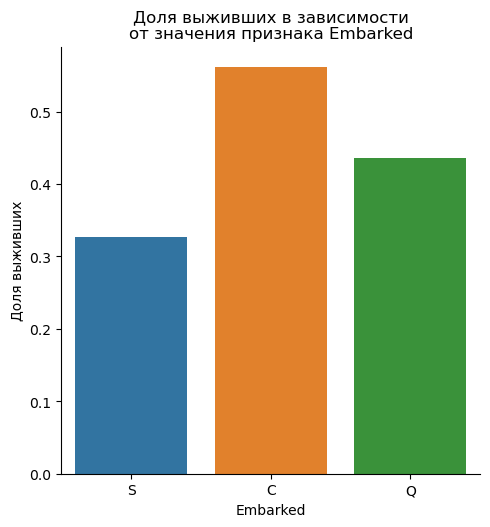

In [78]:
sns.catplot(data=exploratory_set, x='Embarked', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших в зависимости\nот значения признака Embarked')
plt.ylabel('Доля выживших')

plt.show()

### Вывод

1. Присутствует дисбаланс классов
1. Требуется кодирование категориальных признаков
1. Требуется удаление неинформативных признаков
1. Требуется обработка пропусков
1. Требуется стандартизация данных
1. К исследовательскому набору были добавлены новые признаки, информативность которых еще предстоит оценить:
    - `Title`
    - `AgeGroup`
    - `Family`
    - `isFamily`
    - `FareGroup`
    - `Cabin`
    - `Ticket`
1. Возможно наличие корреляции между добавленными и имевшимися признаками

На первый взгляд, очень важными признаками являются класс билета `Pclass` и пол `Sex` пассажира. Могут оказаться полезны признаки `Title`, `AgeGroup`, `isFamily`. Возможно, окажутся информативны `FareGroup` и `isCabin`. Проверим это предположение после обработки данных.

Отметим что женщины имели более высокие шансы спастись, чем мужчины, и что в данных нет явных сведений о том, что более молодые пассажиры имели больше шансов выжить, однако, может оказаться, что некоторые возрастные группы имели больше шансов спастись.

In [79]:
set_notification('Выполнен исследовательский анализ данных.')

## Обработка данных

### Разработка новых признаков
На этапе исследовательского анализа мы определили список новых признаков, которые могут оказаться информативны. Создадим собственные трансформеры для добавления этих признаков к обучающей выборке внутри пайплайна, напишем конвейер обработки данных и оценим информативность признаков на выходе этого конвейера.

Для кодирования категориальных переменных попробуем использовать целевероятностное кодирование с помощью `category_encoders.target_encoder.TargetEncoder`.

#### `Title`
Создадим трансформер, который будет добавлять признак `Title` к обучающей выборке.

In [80]:
def add_title(X, y=None):
    title = X.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?')
    title = pd.Series(title[0], name='Title').str.lower()
    
    title = title.where(title.isin(['mr', 'miss', 'mrs', 'master']), 'aristocratic')
    
    return pd.concat([X, title], axis='columns')

TitleAdder = FunctionTransformer(func=add_title)

#### `AgeGroup` и `FareGroup`
Используем `KBinsDiscretizer` из `sklearn.preprocessing`, чтобы разделить непрерывный признак `Age` на несколько категорий и закодировать их с помощью целевероятностного кодирования (target encoding). Аналогично поступим с признаков `FareGroup`.

Приведём пайплайн, который выполнит эти операции. Предполагается, что приведённый ниже пайплайн - часть `ColumnTransformer` и на вход пайплайна подаются только два признака: `Age` и `FareGroup`. `Age` и `FareGroup` имеют тип `np.float64`, поэтому необходимо указать `TargetEncoder` на эти столбцы, задав атрибут `cols = [0, 1]`.

```Python
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
    ('encoder', TargetEncoder(cols=[0, 1])),
])
```

#### `Family`
Создадим трансформер, который добавляет признак `Family` к обучающей выборке.

In [81]:
def add_family(X, y=None):
    family = X.Parch + X.SibSp
    family.name ='Family'

    return pd.concat([X, family], axis='columns')

FamilyAdder = FunctionTransformer(func=add_family)

#### `isFramily`
Для добавления атрибута `isFramily` будем использовать `sklearn.preprocessing.Binarizer`.

#### `Cabin`

In [82]:
def encode_cabin(X, y=None):
    data = X.copy()
    data.Cabin = data.Cabin.str.slice(stop=1)
    data.loc[data.Cabin.isna(), 'Cabin'] = 'unknown'
    
    return data

CabinEncoder = FunctionTransformer(func=encode_cabin)

#### `Ticket`

In [83]:
def encode_ticket(X, y=None):
    data = X.copy()
    counts = data.Ticket.value_counts()
    data.Ticket = data.Ticket.replace(counts)
    
    return data

TicketEncoder = FunctionTransformer(func=encode_ticket)

#### Отношения атрибутов
Добавим несколько признаков, являющихся отношениями атрибутов.

In [84]:
def get_max(X, y=None):
    return X.to_numpy().max(axis=1)[:, np.newaxis]

GetMax = FunctionTransformer(func=get_max)


def combine_fare_age(X, y=None):
    data = X.copy()
    data.loc[:, 'FareAgeComb'] = data.Fare / data.Age
    
    return data

CombFareAge = FunctionTransformer(func=combine_fare_age)


def combine_fare_pclass(X, y=None):
    data = X.copy()
    data.loc[:, 'FarePclassComb'] = data.Fare / data.Pclass
    
    return data

CombFarePclass = FunctionTransformer(func=combine_fare_pclass)


def combine_sibsp_family(X, y=None):
    data = X.copy()
    data.loc[:, 'SibSpFamilyComb'] = data.SibSp / (data.Family + 1)
    
    return data

CombSibSpFamily = FunctionTransformer(func=combine_sibsp_family)


def combine_parch_family(X, y=None):
    data = X.copy()
    data.loc[:, 'ParchFamilyComb'] = data.Parch / (data.Family + 1)
    
    return data

CombParchFamily = FunctionTransformer(func=combine_parch_family)

### Оценка информативности признаков

#### Конвейер
Создадим конвейер, выполняющий обработку данных.

In [85]:
data_prep = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    ('FareAgeComb', CombFareAge),
    ('FarePclassComb', CombFarePclass),
    ('SibSpFamilyComb', CombSibSpFamily),
    ('ParchFamilyComb', CombParchFamily),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('is_family', Binarizer(), ['Family']),
        ('title_sex_comb', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                   ('get_max', GetMax)
                  ]), 
         ['Sex', 'Title']
        ),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title', 'Cabin', 'Ticket']
        ),
        ('features_discr', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1, 2])),
         ]), 
         ['Age', 'Fare', 'FareAgeComb', 'FarePclassComb']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['Age', 'Fare', 'FareAgeComb', 'SibSp', 'Parch', 'Family', 'FarePclassComb', 'SibSpFamilyComb', 'ParchFamilyComb']
        ),
    ], remainder='passthrough')
    ),        
])

Попробуем обработать с помощью разработанного конвейера обучающую выборку, преобразовать результат в датафрейм и вывести его первые 5 строк.

In [86]:
cols = [
    'isFamily',
    'TitleSexComb',
    'Pclass', 
    'Sex', 
    'Embarked', 
    'Title', 
    'Cabin', 
    'Ticket',
    'AgeGroup', 
    'FareGroup', 
    'FareAgeCombGroup', 
    'FarePclassCombGroup', 
    'Age', 
    'Fare', 
    'FareAgeComb',
    'SibSp', 
    'Parch',
    'Family', 
    'FarePclassComb', 
    'SibSpFamilyComb', 
    'ParchFamilyComb',
]

preprocessed_data = pd.DataFrame(data_prep.fit_transform(X=X_train, y=y_train), columns=cols)
preprocessed_data.head()

,isFamily,TitleSexComb,Pclass,Sex,Embarked,Title,Cabin,Ticket,AgeGroup,FareGroup,...,FarePclassCombGroup,Age,Fare,FareAgeComb,SibSp,Parch,Family,FarePclassComb,SibSpFamilyComb,ParchFamilyComb
0,0.0,0.185185,0.242967,0.185185,0.330116,0.152913,0.291667,0.393732,0.358025,0.603352,...,2.0,-0.081135,0.513812,-0.192552,-0.465084,-0.466183,-0.556339,-0.116956,-0.627576,-0.512903
1,0.0,0.185185,0.446667,0.185185,0.330116,0.152913,0.291667,0.317227,0.358025,0.236487,...,0.0,-0.081135,-0.662563,-0.192552,-0.465084,-0.466183,-0.556339,-0.497054,-0.627576,-0.512903
2,0.0,0.185185,0.649123,0.185185,0.330116,0.152913,0.650252,0.317227,0.358025,0.603352,...,3.0,-0.081135,3.955399,-0.192552,-0.465084,-0.466183,-0.556339,3.979279,-0.627576,-0.512903
3,1.0,0.784980,0.242967,0.743083,0.330116,0.784980,0.291667,0.317227,0.426829,0.252427,...,1.0,-0.887827,-0.467874,-0.197103,-0.465084,0.727782,0.073412,-0.434148,-0.627576,1.949439
4,1.0,0.784980,0.446667,0.743083,0.330116,0.784980,0.291667,0.623187,0.358025,0.435754,...,2.0,0.110934,-0.115977,-0.152221,0.478335,0.727782,0.703162,-0.232143,0.859100,1.128659


#### Корреляция между обучающими признаками
Оценим корреляцию между признаками после обработки данных. Так как в наборе появились качественные признаки (хоть и закодированные), расчитаем коэффициент ранговой корреляции Кендалла.

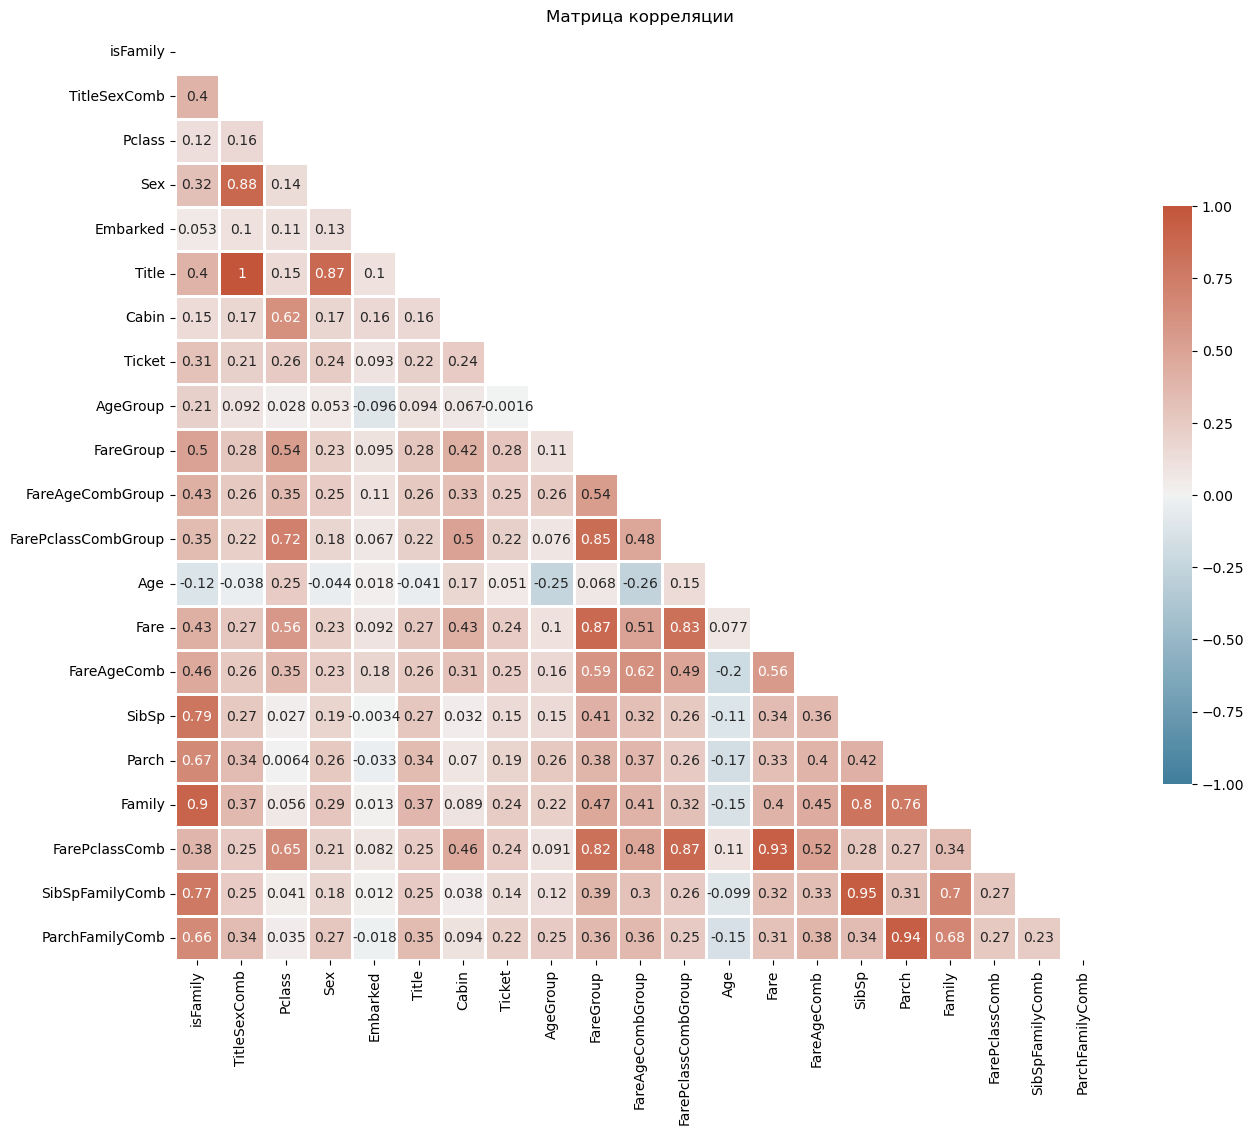

In [87]:
plot_corr_matrix(preprocessed_data, vmin=-1, vmax=1, size=(15, 15), method='kendall')

Мы получили скоррелированные между собой признаки. Если появление корреляции, например, между `Famlily` и `SibSp` ожидаемо, то корреляция между параметрами `Title` и `Sex` выглядит неожиданной, но объяснимой: обращения для мужчин и женщин разлины, а женщины имели более высокие шансы выжить.

В дальнейшем мы отбросим некоторые из сильно скоррелированных признаков.

#### Взаимная информация (Mutual Information)
Чтобы выяснить какие обучающие признаки несут больше всего информации о целевом, оценим метрику Mutual Information с помощью `sklearn.feature_selection.mutual_info_classif`. Оценку будем выполнять дважды при значении параметра `n_neighbors` равном 5 и 100.

In [88]:
def print_mi_scores(df, y_train, n_neighbors, random_state=None):
    
    fig, ax = plt.subplots()
    
    mi_scores = (pd
                 .DataFrame(mutual_info_classif(df, 
                                                y_train, 
                                                n_neighbors=n_neighbors, 
                                                random_state=random_state), 
                            columns=['mutual_info'], 
                            index=df.columns
                           )
                 .sort_values(by='mutual_info', ascending=False)
    )

    (mi_scores
     .round(3)
     .sort_values(by='mutual_info', ascending=True)
     .plot(kind='barh', grid=False, title=f'Mutual information\nn_neighbors={n_neighbors}', ax=ax)
    )

    ax.bar_label(ax.containers[0])
    ax.set_xlim([0, 0.25])
    ax.legend(loc='lower right')
    plt.show()
    
    return mi_scores

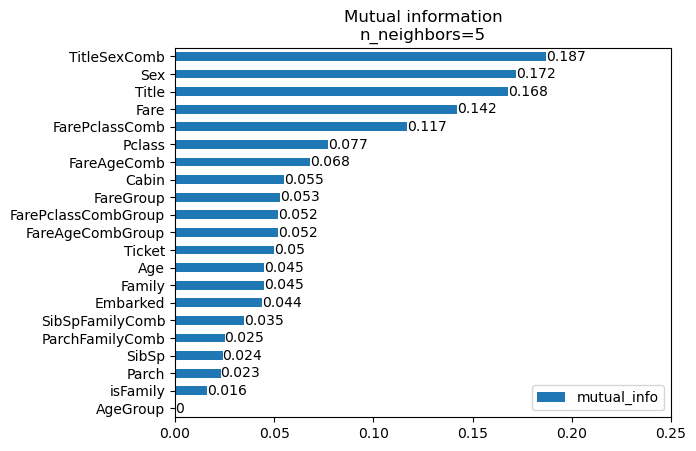

In [89]:
print_mi_scores(preprocessed_data, y_train, 5, random_state=SEED);

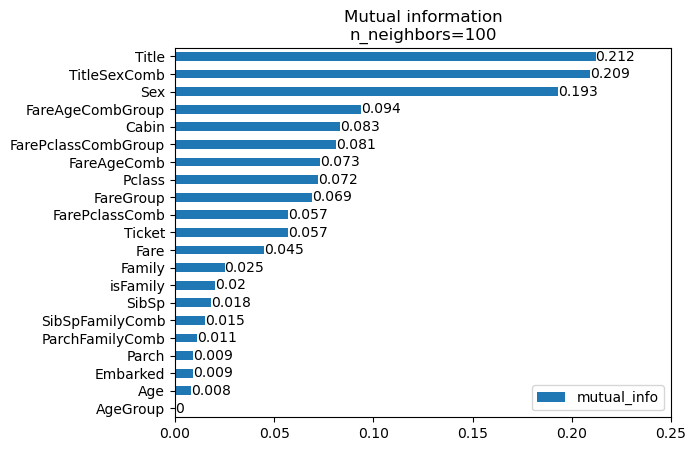

In [90]:
print_mi_scores(preprocessed_data, y_train, 100, random_state=SEED);

Согласно полученным результатам, признаки неравноценны.

In [91]:
set_notification('Выполнена предобработка данных.')

## Удаление скоррелированных признаков
Удалим часть признаков, показывающих высокую корреляцию, и перепишем конвейер.

,TitleSexComb,Pclass,Embarked,Cabin,Ticket,AgeGroup,FareGroup,FareAgeCombGroup,Age,FareAgeComb,Family,SibSpFamilyComb,ParchFamilyComb
0,0.185185,0.242967,0.330116,0.291667,0.393732,0.358025,0.603352,0.331984,-0.081135,-0.192552,-0.556339,-0.627576,-0.512903
1,0.185185,0.446667,0.330116,0.291667,0.317227,0.358025,0.236487,0.331984,-0.081135,-0.192552,-0.556339,-0.627576,-0.512903
2,0.185185,0.649123,0.330116,0.650252,0.317227,0.358025,0.603352,0.331984,-0.081135,-0.192552,-0.556339,-0.627576,-0.512903
3,0.784980,0.242967,0.330116,0.291667,0.317227,0.426829,0.252427,0.336369,-0.887827,-0.197103,0.073412,-0.627576,1.949439
4,0.784980,0.446667,0.330116,0.291667,0.623187,0.358025,0.435754,0.331984,0.110934,-0.152221,0.703162,0.859100,1.128659


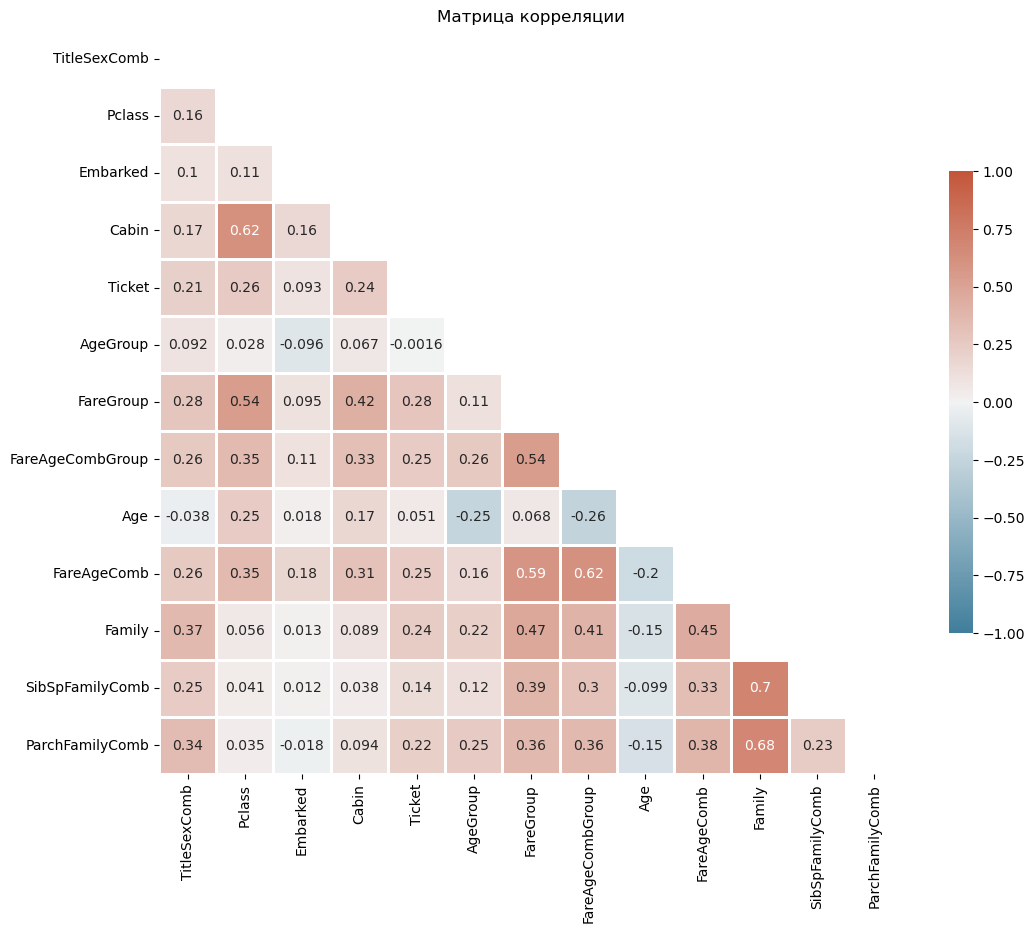

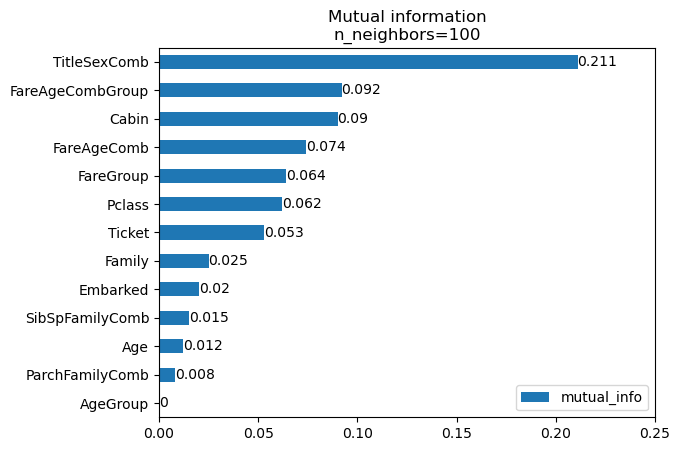

In [92]:
data_prep = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    ('FareAgeComb', CombFareAge),
    ('SibSpFamilyComb', CombSibSpFamily),
    ('ParchFamilyComb', CombParchFamily),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('title_sex_comb', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                   ('get_max', GetMax)
                  ]), 
         ['Sex', 'Title']
        ),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Embarked', 'Cabin', 'Ticket']
        ),
        ('features_discr', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1, 2])),
         ]), 
         ['Age', 'Fare', 'FareAgeComb']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['Age', 'FareAgeComb', 'Family', 'SibSpFamilyComb', 'ParchFamilyComb']
        ),
    ], remainder='drop')
    ),        
])


cols = [
    'TitleSexComb',
    'Pclass', 
    'Embarked', 
    'Cabin', 
    'Ticket',
    'AgeGroup', 
    'FareGroup', 
    'FareAgeCombGroup', 
    'Age', 
    'FareAgeComb',
    'Family', 
    'SibSpFamilyComb', 
    'ParchFamilyComb',
]


preprocessed_data = pd.DataFrame(data_prep.fit_transform(X=X_train, y=y_train), columns=cols)
display(preprocessed_data.head())


plot_corr_matrix(preprocessed_data, vmin=-1, vmax=1, size=(12, 12), method='kendall')


print_mi_scores(preprocessed_data, y_train, 100, random_state=SEED);

Таким образом, после удаления лишних признаков остался следующий набор:
1. `TitleSexComb`;
1. `Pclass`;
1. `Embarked`;
1. `Cabin`;
1. `Ticket`;
1. `AgeGroup`;
1. `FareGroup`;
1. `FareAgeCombGroup`;
1. `Age`;
1. `FareAgeComb`;
1. `Family`;
1. `SibSpFamilyComb`;
1. `ParchFamilyComb`.

In [93]:
set_notification('Удалены скоррелированные признаки.')

## Функции для оценки моделей
Напишем несколько функций, позволяющих быстро оценивать модели.

In [94]:
def get_cv_scores(estimator, X, y, score='accuracy', cv=CV, n_jobs=N_JOBS):
    '''Выполняет кросс-валидацию и возвращает значения целевой метрики.
    По сути, обёртка для cross_val_score с заданными значениями параметров
    cv и n_jobs.
    '''
    
    scores = cross_val_score(estimator,
                             X=X,
                             y=y,
                             cv=cv,
                             scoring=score,
                             n_jobs=n_jobs,
                            )
    
    return scores


def get_train_score(estimator, X, y, score='accuracy'):
    '''Обучает модель на тренировочной выборке и на ней же оценивает 
    заданную метрику.
    '''
    
    scorer = get_scorer(score)
    
    return scorer(estimator.fit(X, y), X, y)


def get_cv_pred(estimator, X, y, method='predict', cv=CV, n_jobs=N_JOBS):
    '''Обёртка вокруг cross_val_predict, возвращающая массив с предсказаниями
    на каждом из фолдов.
    '''
    
    y_pred = cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=n_jobs)
    
    if method == 'predict_proba':
        y_pred = y_pred[:, -1]
        
    return y_pred

In [95]:
def plot_roc_curve_for_random_clf():
    '''Выводит на экран кривую ROC для классификатора, предсказывающего
       целевую переменную случайным образом.
    '''
    
    fig, ax = plt.subplots(1, 1)
    
    ax.plot([0,1], [0,1], 'k--', label='Random classifier')
    ax.grid()
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.legend(loc='lower right')

    ax.set_title('ROC curve')
    
    return fig, ax


def plot_roc_curve(y_train, y_scores, label, ax, style=''):
    '''Печатае кривую ROC на оси ax.'''
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    ax.plot(fpr, tpr, style, label=label)
    
    ax.legend(loc='lower right')
    
    return ax

In [96]:
def agg_scores(scores, label, score_names):
    '''Возвращает датафрейм, содержащий среднее, медианное, минимальное и максимальное 
    значения метрики, полученное с помощью кросс-валидации, и оценку метрики на 
    тренировочном наборе.
    '''
    
    res = (scores
           .query('classifier == @label')[score_names]
           .agg(['min', 'median', 'mean', 'max'])
           .transpose()
           .rename(columns=lambda string: '_'.join(['cv', string]))
          )
    
    cols_with_train_scores = ['train_' + score_name for score_name in score_names]
    train_score = scores.query('classifier == @label').loc[0, cols_with_train_scores]
    
    res.loc[:, 'train_score'] = train_score.transpose().to_numpy()
    
    return res

In [97]:
def score_box_plot(score, metric, aspect=1, rot=0):
    g = sns.catplot(aspect=aspect)

    g = sns.scatterplot(data=score, 
                      x='classifier', 
                      y='train_' + metric, 
                      markers='X', 
                      label=metric + ' на тренировочном наборе'
                     )

    g = sns.boxplot(data=score, x='classifier', y=metric, color='white', showmeans=True)

    g.tick_params(axis='x', rotation=rot)
    g.set_xlabel('Классификатор')
    g.set_ylabel(metric)
    g.set_title(f'Значения метрики {metric} по результатм\nкросс-валидации для разных классификаторов')
    sns.move_legend(g, 'lower right')

    plt.show()

In [98]:
def evaluate_model(estimator, X, y, label, metrics, ax, cv=CV, n_jobs=N_JOBS, method='predict_proba'):
    '''Печатает диаграмму размаха для результатов кросс-валидации указанной метрики.
    Отмечает на диаграмме результат, полученный на тренировочном наборе данных.
    '''
    
    cols = ['classifier'] + metrics + ['train_' + value for value in metrics]
    
    scores = pd.DataFrame(columns = cols)
    
    for metric in metrics:
        scores[metric] = get_cv_scores(estimator, X, y, score=metric, cv=cv, n_jobs=n_jobs)
        scores['train_' + metric] = get_train_score(estimator, X, y, score=metric)

    y_scores = get_cv_pred(estimator, X, y, method=method, cv=cv, n_jobs=n_jobs)
    ax = plot_roc_curve(y, y_scores, label=label, ax=ax)
    
    scores['classifier'] = label
        
    return scores, ax

In [99]:
def compare_models(classifiers, 
                   methods, 
                   labels, 
                   X, 
                   y, 
                   box_plot_aspect=1.0,
                   box_plot_xrot=0,
                   cv=CV, 
                   n_jobs=N_JOBS
                  ):
    
    all_scores = pd.DataFrame()
    
    fig, ax = plot_roc_curve_for_random_clf()
    
    for i, (classifier, method, label) in enumerate(zip(classifiers, methods, labels)):
        print(f'{i+1}. {label}')

        metrics_list = ['accuracy', 'f1', 'roc_auc']

        scores, ax = evaluate_model(estimator=classifier, 
                                    X=X, 
                                    y=y, 
                                    metrics=metrics_list, 
                                    label=label, 
                                    method=method,
                                    ax=ax, 
                                    cv=cv, 
                                    n_jobs=n_jobs
                                   )

        print(f'Значения метрик для {label}')
        display(agg_scores(scores, label=label, score_names=metrics_list))
        
        all_scores = pd.concat([all_scores, scores])


    plt.show()
    
    for metric in metrics_list:
        score_box_plot(all_scores, metric=metric, aspect=box_plot_aspect, rot=box_plot_xrot)
        plt.show()

## Базовая модель
В качестве базовой модели, с которой мы будем сравнивать разработанные модели, будем использовать `sklearn.dummy.DummyClassifier`

1. DummyClassifier
Значения метрик для DummyClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.528169,0.535211,0.547690,0.594406,0.518258
f1,0.411215,0.429907,0.427485,0.446429,0.379374
roc_auc,0.471591,0.508418,0.497736,0.525000,0.513338


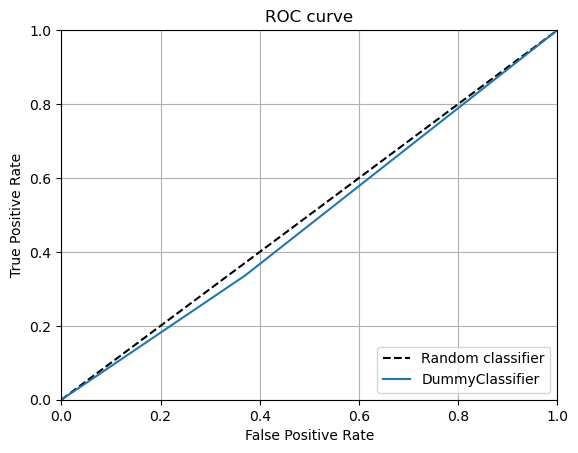

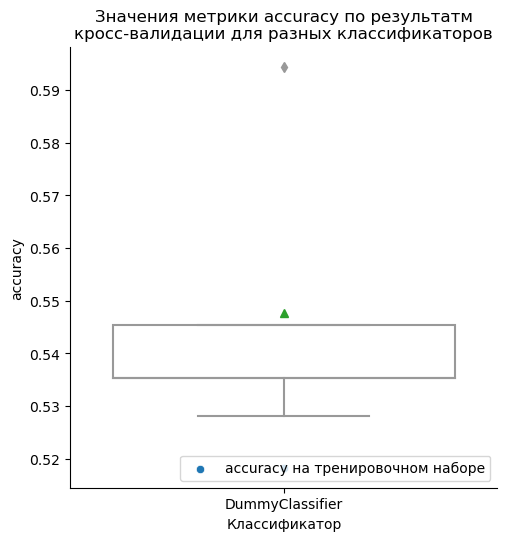

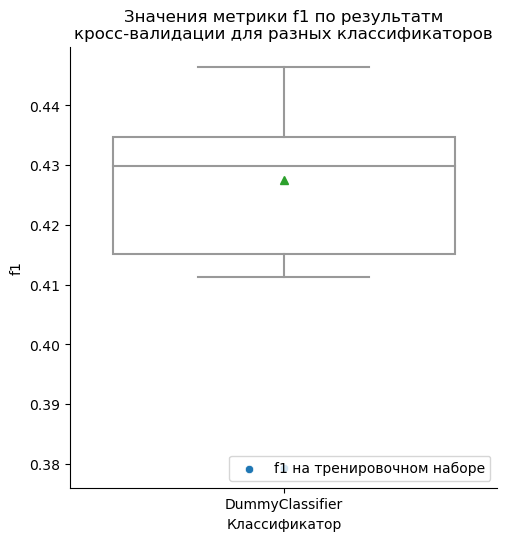

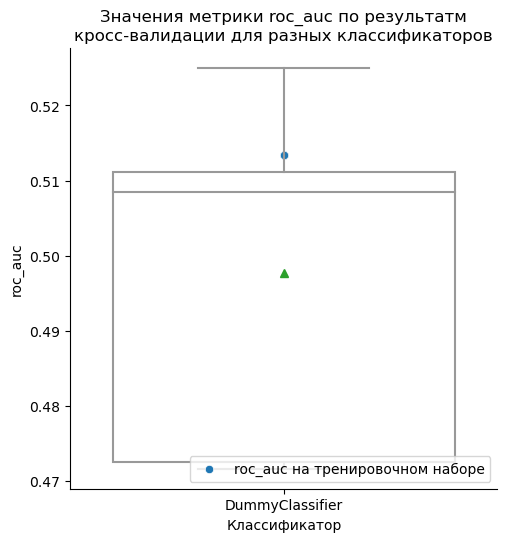

In [100]:
classifiers = [
    DummyClassifier(strategy='stratified')
]

methods = [
    'predict_proba'
]

labels = [
    'DummyClassifier'
]

compare_models(classifiers, methods, labels, X_train, y_train)

In [101]:
set_notification('Оценена базовая модель.')

## Выбор модели

Напишем конвейер для которого мы будем подбирать классификатор. Шаг, предназначенный для классификатора оставим пустым, так как классификатор еще предстоит подобрать. 

Попробуем добавлять к конвейеру разные классификаторы и сравним результаты. Рассмотрим следующие классификаторы с параметрами по умолчанию:
- LogisticRegression;
- SVC;
- KNeighborsClassifier;
- DecisionTreeClassifier;
- RandomFrorestClassifier;
- GradientBoostingClassifier;
- XGBClassifier.

1. LogisticRegression
Значения метрик для LogisticRegression


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.790210,0.823944,0.818891,0.852113,0.824438
f1,0.711538,0.766355,0.758553,0.807339,0.768089
roc_auc,0.839566,0.870041,0.864527,0.875653,0.877056


2. SVC
Значения метрик для SVC


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.795775,0.811189,0.811819,0.830986,0.831461
f1,0.712871,0.728972,0.741760,0.777778,0.770115
roc_auc,0.811260,0.854127,0.846922,0.864256,0.871824


3. KNeighborsClassifier
Значения метрик для KNeighborsClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.727273,0.776224,0.778164,0.809859,0.825843
f1,0.621359,0.697248,0.693829,0.737864,0.766917
roc_auc,0.768802,0.817340,0.807990,0.840909,0.910056


4. DecisionTreeClassifier
Значения метрик для DecisionTreeClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.741259,0.776224,0.778144,0.823944,0.983146
f1,0.666667,0.724138,0.715112,0.763636,0.977612
roc_auc,0.693492,0.751343,0.742159,0.777638,0.999086


5. RandomForestClassifier
Значения метрик для RandomForestClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.748252,0.795775,0.802078,0.852113,0.983146
f1,0.604167,0.752294,0.728887,0.793103,0.977778
roc_auc,0.807851,0.849432,0.851688,0.887416,0.995298


6. XGBClassifier
Значения метрик для XGBClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.748252,0.802817,0.797823,0.823944,0.976124
f1,0.625000,0.750000,0.726604,0.767857,0.968224
roc_auc,0.794835,0.837437,0.834216,0.882786,0.995211


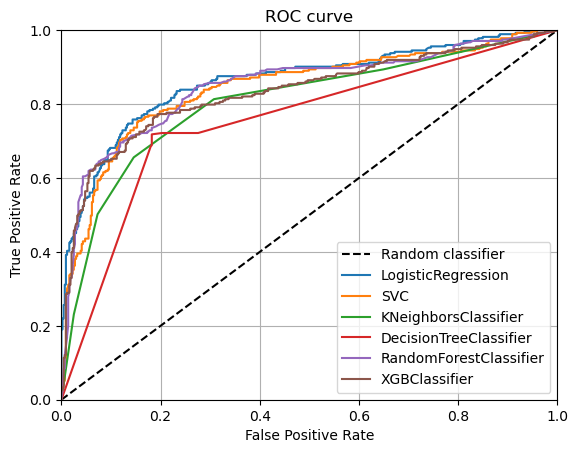

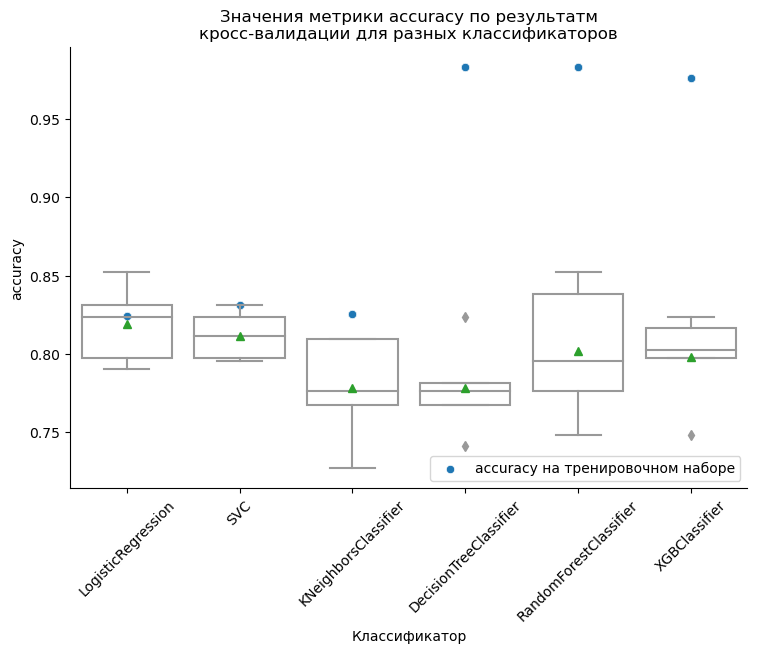

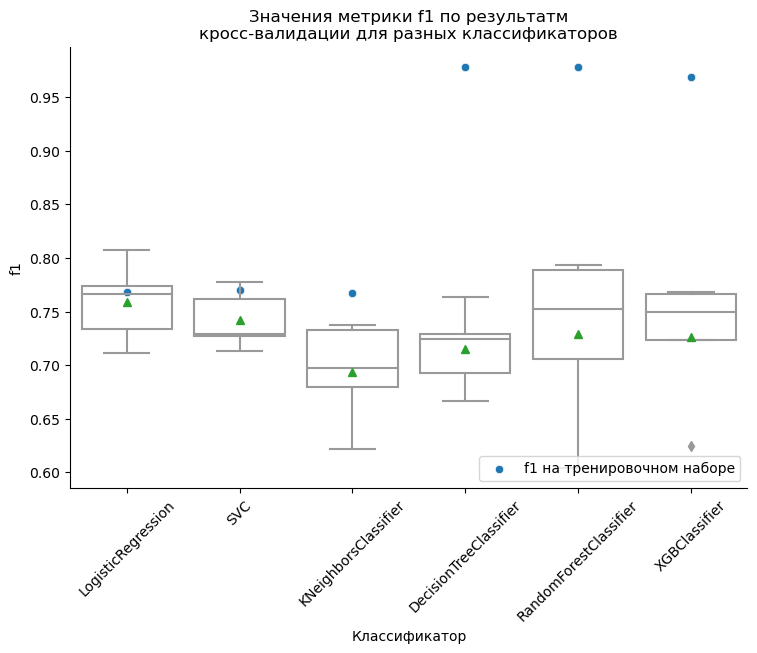

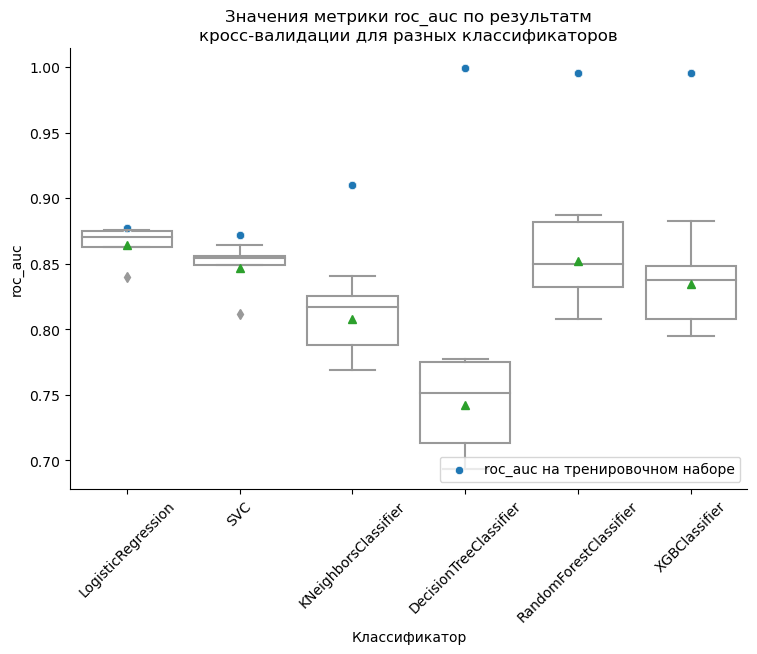

In [102]:
classifiers = [
    LogisticRegression(),
    SVC(kernel='rbf'),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

models = [Pipeline([('data_prep', data_prep), 
                    ('classifier', classifier)
                   ])
          for classifier in classifiers]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'predict_proba',
    'predict_proba',
    'predict_proba',
]

labels = [
    'LogisticRegression',
    'SVC',
    'KNeighborsClassifier',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'XGBClassifier'
]


compare_models(models, methods, labels, X=X_train, y=y_train, box_plot_aspect=1.5, box_plot_xrot=45)

`DecisionTreeClassifier` показал самое низкое значение метрики *ROC_AUC*, далее не будем его рассматривать. Остальные модели показали достаточно хорошие результаты. `LogisticRegression`, `SVC(kernel='rbf')`, `RandomForestClassifier` и `XGBClassifier` показали близкие результаты, при этом медианное значение метрики *accuracy* превысило целевое, либо оказалось очень близко к нему.

На графиках, содержащих диаграммы размаха значений метрик по результатам кросс-валидации, отмечены значения метрик, полученные на тренировочном наборе (модель обучена и оценена на полной обучающей выборке). Значения метрик, полученные на тренировочной выборке, выше мединных значений, полученных на кросс-валидации. Складывается впечатление, что все модели, кроме `LogisticRegression` и `SVC(kernel='rbf')`, демонстрируют оверфитинг.

Попробуем подобрать гиперпараметры для четырёх следующих моделей:
1. `LogisticRegression`,
1. `SVC(kernel='rbf')`,
1. `RandomForestClassifier`,
1. `XGBClassifier`.

In [103]:
set_notification('Оценены модели с параметрами по умолчанию.')

## Настройка гиперпараметров

Добавим в конвейер отбор наиболее информативных признаков из оставшихся с помощью метрики *Mutual Info* и попробуем подобрать гперпараметры моделей. 

In [104]:
classifiers = [
    LogisticRegression(solver='liblinear'),
    SVC(kernel='rbf'),
    RandomForestClassifier(),
    XGBClassifier()
]

def get_mi_score(X, y=None):
    return mutual_info_classif(X, y, n_neighbors=100)

models = [Pipeline([('data_prep', data_prep), 
                    ('feature_selector', SelectKBest(score_func=get_mi_score)),
                    ('classifier', classifier)
                   ])
          for classifier in classifiers]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'predict_proba',
]

labels = [
    'LogisticRegression',
    'SVC',
    'RandomForestClassifier',
    'XGBClassifier'
]


params_list = [
    {
        'feature_selector__k': IntDistribution(low=5, high=13),
        'classifier__C': FloatDistribution(low=0.01, high=10, log=True),
        'classifier__penalty': CategoricalDistribution(['l1', 'l2']),
    },
    
    {    
        'feature_selector__k': IntDistribution(low=5, high=13),
        'classifier__C': FloatDistribution(low=0.01, high=10, log=True),
        'classifier__class_weight': CategoricalDistribution([None, 'balanced']),
        'classifier__gamma': CategoricalDistribution(['scale', 'auto']),
    },
    
    {
        'feature_selector__k': IntDistribution(low=5, high=13),
        'classifier__n_estimators': IntDistribution(low=5, high=100),
        'classifier__max_depth': IntDistribution(low=5, high=100),
        'classifier__min_samples_split': IntDistribution(low=2, high=100),
    },
    
    {    
        'feature_selector__k': IntDistribution(low=5, high=13),
        'classifier__learning_rate': FloatDistribution(low=10**-5, high=0.1, log=True),
        'classifier__n_estimators': IntDistribution(low=5, high=100),
        'classifier__max_depth': IntDistribution(low=3, high=20),
        'classifier__subsample': FloatDistribution(low=0.1, high=1),
    },
]

In [105]:
set_notification('Созданы списки гиперпараметров.')

In [106]:
final_models = list()

for i, (model, label, params) in enumerate(zip(models, labels, params_list)):
    print(f'{i+1}. {label}')
    
    set_notification(f'Настройка гиперпараметров для {label}.')
    
    optuna_search = OptunaSearchCV(estimator=model,
                                   param_distributions=params,
                                   scoring='accuracy',
                                   n_trials=200, 
                                   timeout=600, 
                                   verbose=1, 
                                   cv=CV, 
                                   n_jobs=N_JOBS
                                  )
    
    optuna_search.fit(X=X_train, y=y_train)
    
    print(optuna_search.best_params_, '\n')
    joblib.dump(optuna_search, f'tuned_{label}.pkl')
    final_models.append(optuna_search.best_estimator_)
    
    set_notification(f'Завершена настройка гиперпараметров для {label}.')

/tmp/ipykernel_1175/2317295730.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(estimator=model,
[I 2023-04-06 04:52:49,469] A new study created in memory with name: no-name-920bbaf8-510b-48f7-aef3-b3f93a6498e2
[I 2023-04-06 04:52:49,470] Searching the best hyperparameters using 712 samples...


1. LogisticRegression


[I 2023-04-06 04:53:34,542] Trial 6 finished with value: 0.8146557667684429 and parameters: {'feature_selector__k': 8, 'classifier__C': 4.08154477464167, 'classifier__penalty': 'l1'}. Best is trial 6 with value: 0.8146557667684429.
[I 2023-04-06 04:53:34,599] Trial 13 finished with value: 0.8174726681768936 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.7155355886991264, 'classifier__penalty': 'l2'}. Best is trial 13 with value: 0.8174726681768936.
[I 2023-04-06 04:53:34,695] Trial 4 finished with value: 0.7513641288289176 and parameters: {'feature_selector__k': 10, 'classifier__C': 0.05493575262489369, 'classifier__penalty': 'l2'}. Best is trial 13 with value: 0.8174726681768936.
[I 2023-04-06 04:53:34,705] Trial 7 finished with value: 0.6867723825470304 and parameters: {'feature_selector__k': 12, 'classifier__C': 0.012926911109561819, 'classifier__penalty': 'l2'}. Best is trial 13 with value: 0.8174726681768936.
[I 2023-04-06 04:53:35,031] Trial 1 finished with value: 

[I 2023-04-06 04:54:22,690] Trial 30 finished with value: 0.8146754653796908 and parameters: {'feature_selector__k': 13, 'classifier__C': 1.1404168512594612, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:54:22,702] Trial 31 finished with value: 0.6657638136511375 and parameters: {'feature_selector__k': 7, 'classifier__C': 0.015771299460792743, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:54:22,978] Trial 39 finished with value: 0.8062050625430907 and parameters: {'feature_selector__k': 6, 'classifier__C': 1.6127774509303907, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:54:23,424] Trial 33 finished with value: 0.8005515611149414 and parameters: {'feature_selector__k': 6, 'classifier__C': 9.683064838690855, 'classifier__penalty': 'l1'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:54:23,930] Trial 38 finished with value: 

[I 2023-04-06 04:55:15,410] Trial 67 finished with value: 0.8160642174726682 and parameters: {'feature_selector__k': 11, 'classifier__C': 2.859203170097712, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:55:15,806] Trial 69 finished with value: 0.8132374667585935 and parameters: {'feature_selector__k': 10, 'classifier__C': 2.9310516650599983, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:55:16,261] Trial 68 finished with value: 0.8160445188614203 and parameters: {'feature_selector__k': 10, 'classifier__C': 2.6213505031001927, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:55:17,547] Trial 71 finished with value: 0.8118388653599922 and parameters: {'feature_selector__k': 11, 'classifier__C': 2.7036681301918057, 'classifier__penalty': 'l2'}. Best is trial 36 with value: 0.818851570964247.
[I 2023-04-06 04:55:18,260] Trial 70 finished with value:

[I 2023-04-06 04:56:45,440] Trial 97 finished with value: 0.8146557667684429 and parameters: {'feature_selector__k': 12, 'classifier__C': 5.232793411211061, 'classifier__penalty': 'l1'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:56:45,547] Trial 104 finished with value: 0.8132276174529697 and parameters: {'feature_selector__k': 12, 'classifier__C': 0.41427578903527823, 'classifier__penalty': 'l1'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:56:45,913] Trial 101 finished with value: 0.8146557667684429 and parameters: {'feature_selector__k': 12, 'classifier__C': 5.087363540032187, 'classifier__penalty': 'l1'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:56:46,268] Trial 100 finished with value: 0.8132571653698415 and parameters: {'feature_selector__k': 12, 'classifier__C': 5.648061982902885, 'classifier__penalty': 'l1'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:56:46,819] Trial 111 finished with

[I 2023-04-06 04:57:37,107] Trial 133 finished with value: 0.8146557667684429 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.7550796723278496, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:57:37,343] Trial 129 finished with value: 0.8146557667684429 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.7824700636106251, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:57:37,670] Trial 135 finished with value: 0.8146557667684429 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.7831426449208002, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:57:38,173] Trial 134 finished with value: 0.8104205653501427 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.5296726175239594, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:57:39,278] Trial 140 finished with 

[I 2023-04-06 04:58:29,343] Trial 167 finished with value: 0.8118487146656161 and parameters: {'feature_selector__k': 7, 'classifier__C': 0.5913097266637111, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:58:30,783] Trial 166 finished with value: 0.8146754653796908 and parameters: {'feature_selector__k': 7, 'classifier__C': 0.6432787879061761, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:59:05,472] Trial 168 finished with value: 0.8174628188712696 and parameters: {'feature_selector__k': 7, 'classifier__C': 0.6567769191257297, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:59:06,167] Trial 169 finished with value: 0.8202698709740963 and parameters: {'feature_selector__k': 7, 'classifier__C': 0.596162456753837, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:59:08,413] Trial 174 finished with v

[I 2023-04-06 04:59:26,288] Trial 198 finished with value: 0.8104205653501427 and parameters: {'feature_selector__k': 7, 'classifier__C': 0.45133188476477976, 'classifier__penalty': 'l2'}. Best is trial 74 with value: 0.8216586230670739.
[I 2023-04-06 04:59:26,289] Finished hyperparemeter search!
[I 2023-04-06 04:59:26,295] Refitting the estimator using 712 samples...
[I 2023-04-06 04:59:26,498] Finished refitting! (elapsed time: 0.202 sec.)


{'feature_selector__k': 10, 'classifier__C': 0.6658041093677541, 'classifier__penalty': 'l2'} 

2. SVC


/tmp/ipykernel_1175/2317295730.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(estimator=model,
[I 2023-04-06 04:59:27,117] A new study created in memory with name: no-name-9c254e2e-80ba-42dd-9f7f-b7eee5b5efa7
[I 2023-04-06 04:59:27,118] Searching the best hyperparameters using 712 samples...
[I 2023-04-06 05:00:12,009] Trial 0 finished with value: 0.810371318822023 and parameters: {'feature_selector__k': 12, 'classifier__C': 4.692022836951564, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}. Best is trial 0 with value: 0.810371318822023.
[I 2023-04-06 05:00:12,513] Trial 3 finished with value: 0.8202698709740963 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.17520738861184673, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}. Best is trial 3 with value: 0.8202698709740963.
[I 2023-04-06 05:00:12,889] Trial 1 finished wit

[I 2023-04-06 05:00:59,600] Trial 32 finished with value: 0.7977445090121146 and parameters: {'feature_selector__k': 10, 'classifier__C': 5.520373430741105, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}. Best is trial 9 with value: 0.8216684723726978.
[I 2023-04-06 05:00:59,645] Trial 31 finished with value: 0.7022357923766374 and parameters: {'feature_selector__k': 10, 'classifier__C': 0.0933213151228927, 'classifier__class_weight': None, 'classifier__gamma': 'auto'}. Best is trial 9 with value: 0.8216684723726978.
[I 2023-04-06 05:00:59,682] Trial 29 finished with value: 0.8160445188614203 and parameters: {'feature_selector__k': 9, 'classifier__C': 0.785380072274016, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 9 with value: 0.8216684723726978.
[I 2023-04-06 05:01:00,100] Trial 40 finished with value: 0.8174529695656456 and parameters: {'feature_selector__k': 8, 'classifier__C': 1.6114745021623826, 'classifier__class_weight': 

[I 2023-04-06 05:01:47,685] Trial 52 finished with value: 0.8160346695557964 and parameters: {'feature_selector__k': 8, 'classifier__C': 3.1514544492720606, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 41 with value: 0.823076923076923.
[I 2023-04-06 05:01:47,976] Trial 60 finished with value: 0.8202600216684723 and parameters: {'feature_selector__k': 9, 'classifier__C': 3.5294739835639573, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 41 with value: 0.823076923076923.
[I 2023-04-06 05:01:48,127] Trial 59 finished with value: 0.8132177681473456 and parameters: {'feature_selector__k': 9, 'classifier__C': 3.61106128610312, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 41 with value: 0.823076923076923.
[I 2023-04-06 05:01:48,585] Trial 58 finished with value: 0.8132374667585935 and parameters: {'feature_selector__k': 8, 'classifier__C': 3.5685006166441324, 'classifier__class_weight': None, '

[I 2023-04-06 05:02:37,015] Trial 88 finished with value: 0.7935290062050625 and parameters: {'feature_selector__k': 7, 'classifier__C': 1.999754479201288, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}. Best is trial 74 with value: 0.8244755244755245.
[I 2023-04-06 05:02:37,260] Trial 87 finished with value: 0.8047572146163695 and parameters: {'feature_selector__k': 7, 'classifier__C': 2.0019471569522613, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}. Best is trial 74 with value: 0.8244755244755245.
[I 2023-04-06 05:02:37,535] Trial 86 finished with value: 0.8061656653205949 and parameters: {'feature_selector__k': 7, 'classifier__C': 2.3022167135090346, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale'}. Best is trial 74 with value: 0.8244755244755245.
[I 2023-04-06 05:02:39,231] Trial 89 finished with value: 0.8061656653205949 and parameters: {'feature_selector__k': 7, 'classifier__C': 2.2851957812324053, 'classifier__

[I 2023-04-06 05:03:30,891] Trial 115 finished with value: 0.8174825174825175 and parameters: {'feature_selector__k': 6, 'classifier__C': 6.2279592350587025, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 74 with value: 0.8244755244755245.
[I 2023-04-06 05:03:31,393] Trial 117 finished with value: 0.7964050034472571 and parameters: {'feature_selector__k': 6, 'classifier__C': 0.34715234059960076, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 74 with value: 0.8244755244755245.
[I 2023-04-06 05:03:31,774] Trial 116 finished with value: 0.8174726681768935 and parameters: {'feature_selector__k': 6, 'classifier__C': 6.762556126982675, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 74 with value: 0.8244755244755245.
[I 2023-04-06 05:03:33,771] Trial 119 finished with value: 0.8174726681768935 and parameters: {'feature_selector__k': 6, 'classifier__C': 6.787481736468826, 'classifier__class_weight':

[I 2023-04-06 05:04:57,640] Trial 146 finished with value: 0.8244853737811484 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.6364096872068744, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 146 with value: 0.8244853737811484.
[I 2023-04-06 05:04:57,753] Trial 145 finished with value: 0.8146262188515709 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.6378547958031954, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 146 with value: 0.8244853737811484.
[I 2023-04-06 05:04:57,995] Trial 144 finished with value: 0.8202698709740964 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.6909187630828806, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 146 with value: 0.8244853737811484.
[I 2023-04-06 05:04:58,313] Trial 147 finished with value: 0.8216783216783217 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.8094398370155573, 'classifier__class_weig

[I 2023-04-06 05:05:47,350] Trial 173 finished with value: 0.8188614202698711 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.9026568134773714, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 146 with value: 0.8244853737811484.
[I 2023-04-06 05:05:47,419] Trial 171 finished with value: 0.8202698709740964 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.8784367067561336, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 146 with value: 0.8244853737811484.
[I 2023-04-06 05:05:47,541] Trial 178 finished with value: 0.8188417216586231 and parameters: {'feature_selector__k': 9, 'classifier__C': 1.2633983415809054, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}. Best is trial 146 with value: 0.8244853737811484.
[I 2023-04-06 05:05:47,847] Trial 174 finished with value: 0.8160642174726682 and parameters: {'feature_selector__k': 8, 'classifier__C': 0.9228411598957267, 'classifier__class_weig

{'feature_selector__k': 9, 'classifier__C': 0.5467326889559273, 'classifier__class_weight': None, 'classifier__gamma': 'scale'} 

3. RandomForestClassifier


/tmp/ipykernel_1175/2317295730.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(estimator=model,
[I 2023-04-06 05:06:04,419] A new study created in memory with name: no-name-7eae895b-6df4-4f89-aa3a-5038b900a6b9
[I 2023-04-06 05:06:04,420] Searching the best hyperparameters using 712 samples...
[I 2023-04-06 05:06:39,740] Trial 10 finished with value: 0.8062444597655866 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 10, 'classifier__max_depth': 88, 'classifier__min_samples_split': 74}. Best is trial 10 with value: 0.8062444597655866.
[I 2023-04-06 05:06:42,669] Trial 19 finished with value: 0.7866147936570471 and parameters: {'feature_selector__k': 7, 'classifier__n_estimators': 13, 'classifier__max_depth': 48, 'classifier__min_samples_split': 95}. Best is trial 10 with value: 0.8062444597655866.
[I 2023-04-06 05:06:49,470] Trial 8 finished with value: 0.8

[I 2023-04-06 05:08:02,206] Trial 15 finished with value: 0.8202895695853443 and parameters: {'feature_selector__k': 11, 'classifier__n_estimators': 98, 'classifier__max_depth': 44, 'classifier__min_samples_split': 12}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:08:06,078] Trial 35 finished with value: 0.8245149216980202 and parameters: {'feature_selector__k': 8, 'classifier__n_estimators': 55, 'classifier__max_depth': 7, 'classifier__min_samples_split': 31}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:08:07,495] Trial 25 finished with value: 0.800620506254309 and parameters: {'feature_selector__k': 7, 'classifier__n_estimators': 95, 'classifier__max_depth': 32, 'classifier__min_samples_split': 98}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:08:11,455] Trial 34 finished with value: 0.8161331626120358 and parameters: {'feature_selector__k': 8, 'classifier__n_estimators': 57, 'classifier__max_depth': 8, 'classifier__min_

[I 2023-04-06 05:09:12,603] Trial 47 finished with value: 0.8188811188811188 and parameters: {'feature_selector__k': 8, 'classifier__n_estimators': 97, 'classifier__max_depth': 7, 'classifier__min_samples_split': 21}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:09:12,719] Trial 57 finished with value: 0.8188712695754949 and parameters: {'feature_selector__k': 9, 'classifier__n_estimators': 44, 'classifier__max_depth': 17, 'classifier__min_samples_split': 45}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:09:16,900] Trial 59 finished with value: 0.8174431202600217 and parameters: {'feature_selector__k': 9, 'classifier__n_estimators': 44, 'classifier__max_depth': 17, 'classifier__min_samples_split': 43}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:09:24,455] Trial 63 finished with value: 0.8174825174825175 and parameters: {'feature_selector__k': 9, 'classifier__n_estimators': 41, 'classifier__max_depth': 19, 'classifier__min

[I 2023-04-06 05:10:47,179] Trial 87 finished with value: 0.8034275583571358 and parameters: {'feature_selector__k': 6, 'classifier__n_estimators': 73, 'classifier__max_depth': 26, 'classifier__min_samples_split': 37}. Best is trial 21 with value: 0.8315177779966512.
[I 2023-04-06 05:11:08,620] Trial 89 finished with value: 0.8315276273022751 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 76, 'classifier__max_depth': 26, 'classifier__min_samples_split': 52}. Best is trial 89 with value: 0.8315276273022751.
[I 2023-04-06 05:11:10,890] Trial 94 finished with value: 0.823116320299419 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 57, 'classifier__max_depth': 23, 'classifier__min_samples_split': 52}. Best is trial 89 with value: 0.8315276273022751.
[I 2023-04-06 05:11:11,502] Trial 90 finished with value: 0.8005811090318133 and parameters: {'feature_selector__k': 6, 'classifier__n_estimators': 73, 'classifier__max_depth': 26, 'classifier__m

[I 2023-04-06 05:12:39,669] Trial 119 finished with value: 0.8273416724120949 and parameters: {'feature_selector__k': 11, 'classifier__n_estimators': 78, 'classifier__max_depth': 35, 'classifier__min_samples_split': 59}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:12:42,981] Trial 118 finished with value: 0.8189008174923668 and parameters: {'feature_selector__k': 7, 'classifier__n_estimators': 82, 'classifier__max_depth': 35, 'classifier__min_samples_split': 59}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:12:46,091] Trial 125 finished with value: 0.825874125874126 and parameters: {'feature_selector__k': 11, 'classifier__n_estimators': 78, 'classifier__max_depth': 34, 'classifier__min_samples_split': 66}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:12:46,132] Trial 121 finished with value: 0.8259036737909977 and parameters: {'feature_selector__k': 11, 'classifier__n_estimators': 82, 'classifier__max_depth': 35, 'classifi

[I 2023-04-06 05:14:07,922] Trial 148 finished with value: 0.8231064709937949 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 86, 'classifier__max_depth': 40, 'classifier__min_samples_split': 49}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:14:08,338] Trial 147 finished with value: 0.8245247710036441 and parameters: {'feature_selector__k': 11, 'classifier__n_estimators': 76, 'classifier__max_depth': 32, 'classifier__min_samples_split': 18}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:14:10,435] Trial 150 finished with value: 0.8300994779868018 and parameters: {'feature_selector__k': 11, 'classifier__n_estimators': 87, 'classifier__max_depth': 40, 'classifier__min_samples_split': 49}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:14:10,638] Trial 152 finished with value: 0.8160740667782921 and parameters: {'feature_selector__k': 12, 'classifier__n_estimators': 86, 'classifier__max_depth': 40, 'classi

[I 2023-04-06 05:15:35,127] Trial 179 finished with value: 0.8188712695754949 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 90, 'classifier__max_depth': 22, 'classifier__min_samples_split': 76}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:15:35,185] Trial 176 finished with value: 0.8245050723923963 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 91, 'classifier__max_depth': 31, 'classifier__min_samples_split': 50}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:15:36,156] Trial 177 finished with value: 0.8174726681768935 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 89, 'classifier__max_depth': 22, 'classifier__min_samples_split': 46}. Best is trial 95 with value: 0.8329262287008767.
[I 2023-04-06 05:15:36,514] Trial 178 finished with value: 0.8188811188811188 and parameters: {'feature_selector__k': 10, 'classifier__n_estimators': 93, 'classifier__max_depth': 31, 'classi

{'feature_selector__k': 10, 'classifier__n_estimators': 56, 'classifier__max_depth': 27, 'classifier__min_samples_split': 54} 

4. XGBClassifier


/tmp/ipykernel_1175/2317295730.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(estimator=model,
[I 2023-04-06 05:16:11,147] A new study created in memory with name: no-name-4c154b34-b6ff-44bf-9c8b-0cf0ad5acb2d
[I 2023-04-06 05:16:11,148] Searching the best hyperparameters using 712 samples...
[I 2023-04-06 05:16:46,728] Trial 0 finished with value: 0.8175022160937655 and parameters: {'feature_selector__k': 7, 'classifier__learning_rate': 0.025158677825648942, 'classifier__n_estimators': 7, 'classifier__max_depth': 3, 'classifier__subsample': 0.5847113019549568}. Best is trial 0 with value: 0.8175022160937655.
[I 2023-04-06 05:16:48,895] Trial 5 finished with value: 0.8203191175022159 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 0.08792583865077537, 'classifier__n_estimators': 20, 'classifier__max_depth': 17, 'classifier__subsample': 0.2470728779183784

[I 2023-04-06 05:16:59,593] Trial 20 finished with value: 0.8329459273121245 and parameters: {'feature_selector__k': 9, 'classifier__learning_rate': 0.030346590493810752, 'classifier__n_estimators': 91, 'classifier__max_depth': 13, 'classifier__subsample': 0.822456154772588}. Best is trial 20 with value: 0.8329459273121245.
[I 2023-04-06 05:17:21,778] Trial 30 finished with value: 0.816083916083916 and parameters: {'feature_selector__k': 11, 'classifier__learning_rate': 0.0001217301269530441, 'classifier__n_estimators': 12, 'classifier__max_depth': 4, 'classifier__subsample': 0.8396603419380166}. Best is trial 20 with value: 0.8329459273121245.
[I 2023-04-06 05:17:23,659] Trial 25 finished with value: 0.8343346794051019 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 7.974907640943088e-05, 'classifier__n_estimators': 39, 'classifier__max_depth': 12, 'classifier__subsample': 0.9716089932045219}. Best is trial 25 with value: 0.8343346794051019.
[I 2023-04-06 05:1

[I 2023-04-06 05:17:40,027] Trial 47 finished with value: 0.8273219738008469 and parameters: {'feature_selector__k': 11, 'classifier__learning_rate': 0.01784374196900477, 'classifier__n_estimators': 79, 'classifier__max_depth': 13, 'classifier__subsample': 0.9225656297626946}. Best is trial 25 with value: 0.8343346794051019.
[I 2023-04-06 05:17:55,421] Trial 50 finished with value: 0.8217177189008176 and parameters: {'feature_selector__k': 10, 'classifier__learning_rate': 0.019251546480302792, 'classifier__n_estimators': 25, 'classifier__max_depth': 12, 'classifier__subsample': 0.980293206749056}. Best is trial 25 with value: 0.8343346794051019.
[I 2023-04-06 05:17:57,371] Trial 53 finished with value: 0.8245149216980202 and parameters: {'feature_selector__k': 12, 'classifier__learning_rate': 0.015472751624407635, 'classifier__n_estimators': 29, 'classifier__max_depth': 12, 'classifier__subsample': 0.934064663001815}. Best is trial 25 with value: 0.8343346794051019.
[I 2023-04-06 05:17

[I 2023-04-06 05:18:37,281] Trial 73 finished with value: 0.8216980202895696 and parameters: {'feature_selector__k': 8, 'classifier__learning_rate': 0.0009628844580663126, 'classifier__n_estimators': 84, 'classifier__max_depth': 14, 'classifier__subsample': 0.889890260008512}. Best is trial 61 with value: 0.8343543780163497.
[I 2023-04-06 05:18:38,825] Trial 72 finished with value: 0.8202994188909681 and parameters: {'feature_selector__k': 8, 'classifier__learning_rate': 0.0006361775742299305, 'classifier__n_estimators': 100, 'classifier__max_depth': 14, 'classifier__subsample': 0.9071755574809409}. Best is trial 61 with value: 0.8343543780163497.
[I 2023-04-06 05:18:45,798] Trial 74 finished with value: 0.8343642273219738 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 0.0006121479016852046, 'classifier__n_estimators': 87, 'classifier__max_depth': 14, 'classifier__subsample': 0.8953928797421241}. Best is trial 74 with value: 0.8343642273219738.
[I 2023-04-06 0

[I 2023-04-06 05:19:28,262] Trial 96 finished with value: 0.8329459273121245 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 2.9811054414163208e-05, 'classifier__n_estimators': 91, 'classifier__max_depth': 16, 'classifier__subsample': 0.8738355397207506}. Best is trial 90 with value: 0.8357628287205751.
[I 2023-04-06 05:19:29,187] Trial 97 finished with value: 0.8329459273121245 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 2.101202542111837e-05, 'classifier__n_estimators': 93, 'classifier__max_depth': 16, 'classifier__subsample': 0.8707545336422045}. Best is trial 90 with value: 0.8357628287205751.
[I 2023-04-06 05:19:29,489] Trial 98 finished with value: 0.8315374766078991 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 3.48591428352163e-05, 'classifier__n_estimators': 93, 'classifier__max_depth': 16, 'classifier__subsample': 0.8750182058092575}. Best is trial 90 with value: 0.8357628287205751.
[I 2023-04-06

[I 2023-04-06 05:20:09,590] Trial 122 finished with value: 0.8301487245149216 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 0.00045889452064058875, 'classifier__n_estimators': 50, 'classifier__max_depth': 11, 'classifier__subsample': 0.8257518090635322}. Best is trial 112 with value: 0.8371614301191765.
[I 2023-04-06 05:20:12,454] Trial 121 finished with value: 0.8273219738008469 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 0.00045647517114041463, 'classifier__n_estimators': 80, 'classifier__max_depth': 6, 'classifier__subsample': 0.9542048003199106}. Best is trial 112 with value: 0.8371614301191765.
[I 2023-04-06 05:20:19,933] Trial 123 finished with value: 0.8273219738008469 and parameters: {'feature_selector__k': 13, 'classifier__learning_rate': 0.00041360828648909, 'classifier__n_estimators': 81, 'classifier__max_depth': 6, 'classifier__subsample': 0.9491674099433777}. Best is trial 112 with value: 0.8371614301191765.
[I 2023-0

[I 2023-04-06 05:20:51,617] Trial 135 finished with value: 0.8329360780065006 and parameters: {'feature_selector__k': 12, 'classifier__learning_rate': 0.0013191547632292826, 'classifier__n_estimators': 81, 'classifier__max_depth': 11, 'classifier__subsample': 0.9415227284053893}. Best is trial 112 with value: 0.8371614301191765.
[I 2023-04-06 05:21:00,303] Trial 144 finished with value: 0.8315177779966512 and parameters: {'feature_selector__k': 12, 'classifier__learning_rate': 0.00023966588321620733, 'classifier__n_estimators': 81, 'classifier__max_depth': 8, 'classifier__subsample': 0.962962820286602}. Best is trial 112 with value: 0.8371614301191765.
[I 2023-04-06 05:21:03,621] Trial 147 finished with value: 0.8343346794051019 and parameters: {'feature_selector__k': 12, 'classifier__learning_rate': 0.0013845083814009703, 'classifier__n_estimators': 41, 'classifier__max_depth': 8, 'classifier__subsample': 0.96292852808958}. Best is trial 112 with value: 0.8371614301191765.
[I 2023-04-

[I 2023-04-06 05:21:32,703] Trial 168 finished with value: 0.8357431301093273 and parameters: {'feature_selector__k': 12, 'classifier__learning_rate': 0.0008815146058791313, 'classifier__n_estimators': 65, 'classifier__max_depth': 10, 'classifier__subsample': 0.9787798691508782}. Best is trial 162 with value: 0.8385403329065302.
[I 2023-04-06 05:21:41,514] Trial 169 finished with value: 0.8371417315079286 and parameters: {'feature_selector__k': 12, 'classifier__learning_rate': 0.0017653033626859687, 'classifier__n_estimators': 63, 'classifier__max_depth': 10, 'classifier__subsample': 0.9803017937211506}. Best is trial 162 with value: 0.8385403329065302.
[I 2023-04-06 05:21:50,196] Trial 177 finished with value: 0.8273022751895992 and parameters: {'feature_selector__k': 11, 'classifier__learning_rate': 0.0008325504266052532, 'classifier__n_estimators': 16, 'classifier__max_depth': 10, 'classifier__subsample': 0.9995393512093439}. Best is trial 162 with value: 0.8385403329065302.
[I 2023

[I 2023-04-06 05:22:15,600] Trial 186 finished with value: 0.8301388752092977 and parameters: {'feature_selector__k': 11, 'classifier__learning_rate': 0.0023752634839082623, 'classifier__n_estimators': 61, 'classifier__max_depth': 7, 'classifier__subsample': 0.9286585223873559}. Best is trial 162 with value: 0.8385403329065302.
[I 2023-04-06 05:22:17,981] Trial 193 finished with value: 0.8329262287008767 and parameters: {'feature_selector__k': 11, 'classifier__learning_rate': 0.0023330767041439956, 'classifier__n_estimators': 60, 'classifier__max_depth': 7, 'classifier__subsample': 0.9328318629267864}. Best is trial 162 with value: 0.8385403329065302.
[I 2023-04-06 05:22:19,892] Trial 195 finished with value: 0.8301290259036737 and parameters: {'feature_selector__k': 11, 'classifier__learning_rate': 0.002253078441447201, 'classifier__n_estimators': 55, 'classifier__max_depth': 7, 'classifier__subsample': 0.9298949248051988}. Best is trial 162 with value: 0.8385403329065302.
[I 2023-04-

{'feature_selector__k': 12, 'classifier__learning_rate': 0.0019330490971235658, 'classifier__n_estimators': 59, 'classifier__max_depth': 7, 'classifier__subsample': 0.9775029369014148} 



In [107]:
set_notification('Настройка гиперпараметров завершена.')

Оценим настроенные модели

1. LogisticRegression
Значения метрик для LogisticRegression


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.804196,0.809859,0.814636,0.830986,0.820225
f1,0.725490,0.761905,0.756682,0.781818,0.765152
roc_auc,0.849793,0.864050,0.866875,0.886102,0.87285


2. SVC
Значения метрик для SVC


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.797203,0.830986,0.821678,0.838028,0.828652
f1,0.723810,0.730769,0.749476,0.796296,0.770713
roc_auc,0.817045,0.848140,0.845604,0.861322,0.864882


3. RandomForestClassifier
Значения метрик для RandomForestClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.783217,0.830986,0.820329,0.852113,0.849719
f1,0.714286,0.764706,0.765325,0.811321,0.79925
roc_auc,0.820248,0.881505,0.873333,0.901410,0.916055


4. XGBClassifier
Значения метрик для XGBClassifier


,cv_min,cv_median,cv_mean,cv_max,train_score
accuracy,0.818182,0.845070,0.838540,0.866197,0.90309
f1,0.717391,0.788462,0.768239,0.819048,0.866019
roc_auc,0.834194,0.865320,0.866169,0.905303,0.918396


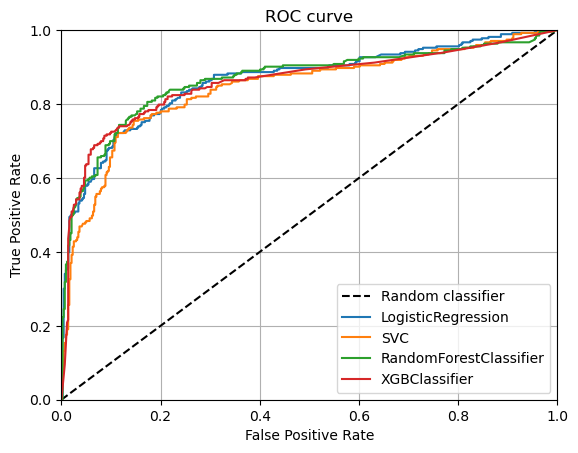

/opt/conda/envs/titanic/lib/python3.9/site-packages/seaborn/utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


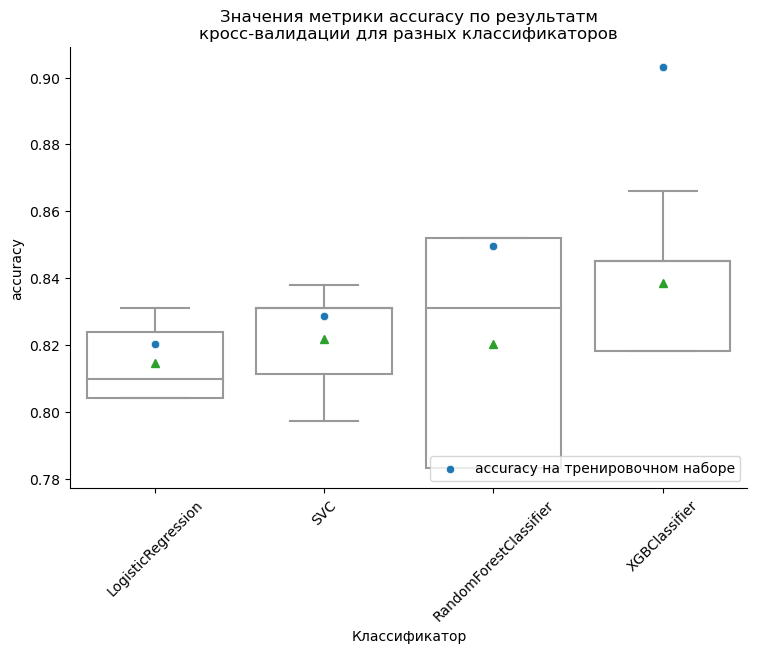

/opt/conda/envs/titanic/lib/python3.9/site-packages/seaborn/utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


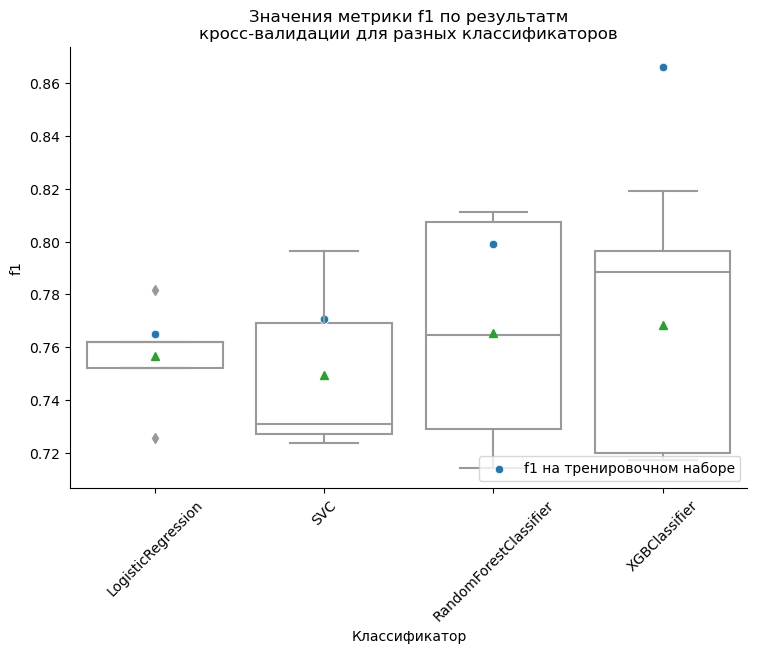

/opt/conda/envs/titanic/lib/python3.9/site-packages/seaborn/utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


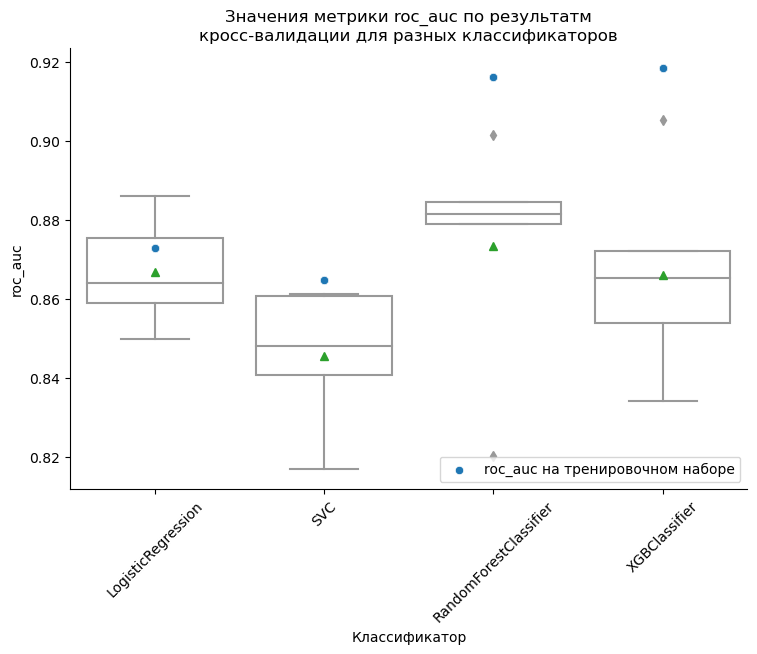

In [108]:
compare_models(final_models, methods, labels, X=X_train, y=y_train, box_plot_aspect=1.5, box_plot_xrot=45)

Лучшую медианную точность на кросс-валидации показал случайный лес (`RandomForestClassifier`), хотя он и продалжает демонстрировать оверфитинг остановимся на нём. Выполним для него оценку точности предсказаний на тестовом наборе и подготовим данные для отправки на Kaggle.

In [109]:
set_notification('Оценены настроенные модели.')

## Проверка на тестовой выборке
Выполним оценку целевой метрики для `RandomForestClassifier` на тестовой выборке.

In [110]:
model = final_models[2]
model.fit(X_train, y_train)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, model.predict(X_test)):.4f}')

Accuracy на тестовой выборке: 0.8212


Оценка *accuracy* на тестовой выборке немного не дотянула до целевого значения 0.8. Тем не менее, нам удалось очень близко подобраться к этому значению.

Для того, чтобы улучшить показатели модели можно попробовать следующее:
- удалить выбросы в данных;
- разработать более информативные признаки;
- избавиться от дисбаланса классов с помощью апсемплинга или даунсемплинга;
- продолжить настройку гиперпараметров и побороть оставшийся оверфитинг;
- попробовать использовать более мощный классификатор;
- попробовать объединить классификаторы в ансамбль.

Остановимся на текущей модели и подготовим данные для Kaggle.

In [111]:
set_notification('Выполнена оценка на тестовой метрике.')

## Подготовка результатов для Kaggle
Подготовим данные для отправки на Kaggle.

In [112]:
model.fit(X, y)

display(submission_X.head())

submission_y = model.predict(submission_X)


submission = pd.DataFrame({'PassengerId': submission_X.PassengerId,
                           'Survived': submission_y,
                          }
                         )

display(submission.head())


submission.to_csv('submission.csv', index=False)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [113]:
set_notification('Подготовлены данные для отправки на Kaggle.')

После отправки платформа сообщила о следующем результате:
![Результат на Kaggle](scores_on_kaggle.PNG)

Довольно скромный результат, возможно, однажды его получится улучшить :)